In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import json
import os

In [ ]:
np.random.seed(42)
torch.manual_seed(42)


In [ ]:
CONFIG = {
    'countries':['CH', 'FR', 'AT'],   # Switzerland, France, Austria
    'lookback': 168,  # 7 days of hourly data as input
    'horizon': 24,  # Predict next 24 hours
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.2,
    'early_stopping_patience': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

Using device: cuda


In [ ]:
def download_opsd_data():
    """Download OPSD hourly time series data"""
    print("Downloading OPSD data...")
    url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"

    try:
        df = pd.read_csv(url, parse_dates=['utc_timestamp'], low_memory=False)
        print(f"Downloaded data shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error downloading: {e}")
        print("Creating synthetic data for demonstration...")
        return create_synthetic_data()


In [ ]:
def create_synthetic_data():
    """Create synthetic data if download fails"""
    dates = pd.date_range('2019-01-01', '2020-12-31 23:00:00', freq='H')
    n = len(dates)

    data = {'utc_timestamp': dates}

    for country in CONFIG['countries']:
        # Base load with trend
        base = 40000 + np.linspace(0, 5000, n)

        # Daily seasonality
        hourly = 10000 * np.sin(2 * np.pi * np.arange(n) / 24)

        # Weekly seasonality
        weekly = 5000 * np.sin(2 * np.pi * np.arange(n) / (24*7))

        # Random noise
        noise = np.random.normal(0, 2000, n)

        load = base + hourly + weekly + noise
        data[f'{country}_load_actual_entsoe_transparency'] = load

        # Optional: wind and solar
        data[f'{country}_wind_generation_actual'] = np.maximum(0, 5000 + 3000 * np.random.randn(n))
        data[f'{country}_solar_generation_actual'] = np.maximum(0,
            3000 * np.sin(2 * np.pi * (np.arange(n) % 24) / 24) * (np.random.rand(n) * 0.5 + 0.75))

    return pd.DataFrame(data)

In [ ]:
def prepare_country_data(df, country):
    """Prepare data for one country"""
    print(f"\nPreparing data for {country}...")

    # Select columns
    load_col = f'{country}_load_actual_entsoe_transparency'
    wind_col = f'{country}_wind_generation_actual'
    solar_col = f'{country}_solar_generation_actual'

    country_df = df[['utc_timestamp']].copy()
    country_df.rename(columns={'utc_timestamp': 'timestamp'}, inplace=True)

    if load_col in df.columns:
        country_df['load'] = df[load_col]
    else:
        raise ValueError(f"Load column not found for {country}")

    # Add wind and solar if available
    if wind_col in df.columns:
        country_df['wind'] = df[wind_col].fillna(0)
    if solar_col in df.columns:
        country_df['solar'] = df[solar_col].fillna(0)

    # Drop missing load
    country_df = country_df.dropna(subset=['load'])
    country_df = country_df.sort_values('timestamp').reset_index(drop=True)

    # Add calendar features
    country_df['hour'] = country_df['timestamp'].dt.hour
    country_df['dayofweek'] = country_df['timestamp'].dt.dayofweek
    country_df['month'] = country_df['timestamp'].dt.month
    country_df['dayofyear'] = country_df['timestamp'].dt.dayofyear

    # Cyclical encoding
    country_df['hour_sin'] = np.sin(2 * np.pi * country_df['hour'] / 24)
    country_df['hour_cos'] = np.cos(2 * np.pi * country_df['hour'] / 24)
    country_df['dow_sin'] = np.sin(2 * np.pi * country_df['dayofweek'] / 7)
    country_df['dow_cos'] = np.cos(2 * np.pi * country_df['dayofweek'] / 7)

    print(f"  Shape: {country_df.shape}")
    print(f"  Date range: {country_df['timestamp'].min()} to {country_df['timestamp'].max()}")
    print(f"  Load range: {country_df['load'].min():.0f} to {country_df['load'].max():.0f}")

    return country_df

In [ ]:
class LoadForecastDataset(Dataset):
    """PyTorch Dataset for load forecasting"""

    def __init__(self, data, lookback, horizon, features):
        self.data = data
        self.lookback = lookback
        self.horizon = horizon
        self.features = features
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        # Prepare sequences
        # print(f"Debug: Initializing LoadForecastDataset with data shape: {data.shape if isinstance(data, pd.DataFrame) else 'Not a DataFrame'}")
        # print(f"Debug: Features for dataset: {features}")
        self.X, self.y = self._create_sequences()

    def _create_sequences(self):
        X_list, y_list = [], []

        feature_cols = self.features

        # Debugging prints
        # print(f"Debug: In _create_sequences. self.data type: {type(self.data)}")
        # if isinstance(self.data, pd.DataFrame):
        #     print(f"Debug: self.data columns: {self.data.columns.tolist()}")
        #     print(f"Debug: feature_cols: {feature_cols}")
        #     for col in feature_cols:
        #         if col not in self.data.columns:
        #             print(f"ERROR: Feature '{col}' missing from data DataFrame!")
        # else:
        #     print("ERROR: self.data is not a pandas DataFrame!")

        X_data = self.data[feature_cols].values
        y_data = self.data['load'].values.reshape(-1, 1)

        # Fit scalers
        self.scaler_X.fit(X_data)
        self.scaler_y.fit(y_data)

        # Transform
        X_scaled = self.scaler_X.transform(X_data)
        y_scaled = self.scaler_y.transform(y_data)

        for i in range(len(X_scaled) - self.lookback - self.horizon + 1):
            X_list.append(X_scaled[i:i+self.lookback])
            y_list.append(y_scaled[i+self.lookback:i+self.lookback+self.horizon].flatten())

        return np.array(X_list), np.array(y_list)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [ ]:
def create_dataloaders(country_df, lookback, horizon):
    """Create train, val, test dataloaders"""
    try:
        # Features to use
        base_features = ['load', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
        if 'wind' in country_df.columns:
            base_features.append('wind')
        if 'solar' in country_df.columns:
            base_features.append('solar')

        # Split data: 80% train, 10% val, 10% test
        n = len(country_df)
        train_end = int(0.8 * n)
        val_end = int(0.9 * n)

        train_data = country_df.iloc[:train_end].copy().reset_index(drop=True)
        val_data = country_df.iloc[train_end:val_end].copy().reset_index(drop=True)
        test_data = country_df.iloc[val_end:].copy().reset_index(drop=True)

        print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

        # Create datasets
        print("Debug: Creating train_dataset...")
        train_dataset = LoadForecastDataset(train_data, lookback, horizon, base_features)
        print("Debug: Creating val_dataset...")
        val_dataset = LoadForecastDataset(val_data, lookback, horizon, base_features)
        print("Debug: Creating test_dataset...")
        test_dataset = LoadForecastDataset(test_data, lookback, horizon, base_features)

        # Create dataloaders
        print("Debug: Creating train_loader...")
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
        print("Debug: Creating val_loader...")
        val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
        print("Debug: Creating test_loader...")
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
        print("Debug: All dataloaders created, returning...")

        return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset
    except Exception as e:
        print(f"An error occurred in create_dataloaders: {e}")
        import traceback
        traceback.print_exc()
        return None

In [ ]:

class GRUModel(nn.Module):
    """GRU-based forecasting model"""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        gru_out, _ = self.gru(x)
        # Take last output
        last_out = gru_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)
        return out

In [ ]:
class LSTMModel(nn.Module):
    """LSTM-based forecasting model"""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)
        return out


In [ ]:
class AttentionLayer(nn.Module):
    """Attention mechanism"""

    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attention_weights * lstm_output, dim=1)
        return context, attention_weights


In [ ]:
class LSTMAttentionModel(nn.Module):
    """LSTM with Attention mechanism"""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMAttentionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = AttentionLayer(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attention_weights = self.attention(lstm_out)
        out = self.dropout(context)
        out = self.fc(out)
        return out


In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, patience, device):
    """Train the model with early stopping"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    return model, train_losses, val_losses

In [ ]:
def predict(model, dataloader, dataset, device):
    """Make predictions and inverse transform"""
    model.eval()
    predictions = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)

    # Inverse transform
    predictions_inv = dataset.scaler_y.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)

    return predictions_inv

In [ ]:
def calculate_metrics(y_true, y_pred):
    """Calculate forecasting metrics"""
    # Flatten arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Remove any NaN or Inf
    mask = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
    y_true_flat = y_true_flat[mask]
    y_pred_flat = y_pred_flat[mask]

    mse = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100

    # sMAPE
    smape = np.mean(2 * np.abs(y_pred_flat - y_true_flat) / (np.abs(y_true_flat) + np.abs(y_pred_flat) + 1e-8)) * 100

    # MASE (using naive seasonal forecast with period=24)
    naive_errors = []
    for i in range(24, len(y_true_flat)):
        naive_errors.append(abs(y_true_flat[i] - y_true_flat[i-24]))
    mae_naive = np.mean(naive_errors) if naive_errors else 1.0
    mase = mae / (mae_naive + 1e-8)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'sMAPE': smape,
        'MASE': mase
    }


In [ ]:

def detect_anomalies_zscore(df_test, y_true, y_pred, window=336, threshold=3.0):
    """Detect anomalies using z-score on residuals"""
    residuals = y_true.flatten() - y_pred.flatten()

    # Rolling z-score
    z_scores = []
    flags = []

    for i in range(len(residuals)):
        if i < window:
            z_scores.append(0)
            flags.append(0)
        else:
            window_residuals = residuals[max(0, i-window):i]
            mean_res = np.mean(window_residuals)
            std_res = np.std(window_residuals)
            z = (residuals[i] - mean_res) / (std_res + 1e-8)
            z_scores.append(z)
            flags.append(1 if abs(z) >= threshold else 0)

    return np.array(z_scores), np.array(flags)

In [ ]:
def create_anomaly_labels(z_scores, y_true, y_pred, lo=None, hi=None):
    """Create silver labels for ML anomaly detection"""
    labels = []

    for i in range(len(z_scores)):
        # Positive if |z| >= 3.5
        if abs(z_scores[i]) >= 3.5:
            labels.append(1)
        # Or if outside prediction interval and |z| >= 2.5
        elif lo is not None and hi is not None:
            if (y_true[i] < lo[i] or y_true[i] > hi[i]) and abs(z_scores[i]) >= 2.5:
                labels.append(1)
            elif abs(z_scores[i]) < 1.0 and lo[i] <= y_true[i] <= hi[i]:
                labels.append(0)
            else:
                labels.append(-1)  # Uncertain
        else:
            # Negative if |z| < 1.0
            if abs(z_scores[i]) < 1.0:
                labels.append(0)
            else:
                labels.append(-1)  # Uncertain

    return np.array(labels)

In [ ]:
def detect_anomalies_zscore(df_test, y_true, y_pred, window=336, threshold=3.0):
    """Detect anomalies using z-score on residuals"""
    residuals = y_true.flatten() - y_pred.flatten()

    # Rolling z-score
    z_scores = []
    flags = []

    for i in range(len(residuals)):
        if i < window:
            z_scores.append(0)
            flags.append(0)
        else:
            window_residuals = residuals[max(0, i-window):i]
            mean_res = np.mean(window_residuals)
            std_res = np.std(window_residuals)
            z = (residuals[i] - mean_res) / (std_res + 1e-8)
            z_scores.append(z)
            flags.append(1 if abs(z) >= threshold else 0)

    return np.array(z_scores), np.array(flags)

def create_anomaly_labels(z_scores, y_true, y_pred, lo=None, hi=None):
    """Create silver labels for ML anomaly detection"""
    labels = []

    for i in range(len(z_scores)):
        # Positive if |z| >= 3.5
        if abs(z_scores[i]) >= 3.5:
            labels.append(1)
        # Or if outside prediction interval and |z| >= 2.5
        elif lo is not None and hi is not None:
            if (y_true[i] < lo[i] or y_true[i] > hi[i]) and abs(z_scores[i]) >= 2.5:
                labels.append(1)
            elif abs(z_scores[i]) < 1.0 and lo[i] <= y_true[i] <= hi[i]:
                labels.append(0)
            else:
                labels.append(-1)  # Uncertain
        else:
            # Negative if |z| < 1.0
            if abs(z_scores[i]) < 1.0:
                labels.append(0)
            else:
                labels.append(-1)  # Uncertain

    return np.array(labels)

def train_anomaly_classifier(df_test, y_true, y_pred, z_scores, labels):
    """Train ML classifier for anomaly detection"""
    # Create features
    df_features = df_test.copy().reset_index(drop=True)

    # Add lag features
    for lag in [1, 6, 12, 24]:
        df_features[f'load_lag_{lag}'] = df_features['load'].shift(lag)

    # Rolling statistics
    df_features['load_roll_mean_24'] = df_features['load'].rolling(24).mean()
    df_features['load_roll_std_24'] = df_features['load'].rolling(24).std()

    # Add z_score and prediction error
    df_features['z_score'] = np.pad(z_scores, (0, len(df_features) - len(z_scores)), constant_values=0)
    df_features['pred_error'] = np.pad(y_true.flatten() - y_pred.flatten(),
                                       (0, len(df_features) - len(y_true.flatten())),
                                       constant_values=0)

    df_features = df_features.dropna()

    # Align labels
    labels_aligned = labels[:len(df_features)]

    # Filter certain labels
    certain_mask = labels_aligned != -1
    df_features_certain = df_features[certain_mask]
    labels_certain = labels_aligned[certain_mask]

    if len(labels_certain) < 50:
        print("Not enough labeled samples for ML training")
        return None, {}

    # Select features
    feature_cols = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
                   'load_lag_1', 'load_lag_6', 'load_lag_24',
                   'load_roll_mean_24', 'load_roll_std_24',
                   'z_score', 'pred_error']

    X_ml = df_features_certain[feature_cols].values
    y_ml = labels_certain

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42, stratify=y_ml)

    # Train logistic regression
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred_ml = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    # F1 at precision = 0.80
    precisions = []
    f1s = []
    for thresh in np.linspace(0, 1, 100):
        y_pred_thresh = (y_proba >= thresh).astype(int)
        if y_pred_thresh.sum() > 0:
            prec = precision_score(y_test, y_pred_thresh, zero_division=0)
            f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
            precisions.append(prec)
            f1s.append(f1)

    # Find F1 at precision closest to 0.80
    target_precision = 0.80
    idx = np.argmin([abs(p - target_precision) for p in precisions])
    f1_at_p80 = f1s[idx] if len(f1s) > 0 else 0.0

    metrics = {
        'PR_AUC': pr_auc,
        'F1_at_P80': f1_at_p80,
        'n_samples': len(y_ml),
        'n_positives': int(y_ml.sum()),
        'n_negatives': int((y_ml == 0).sum())
    }

    print(f"  Anomaly ML - PR-AUC: {pr_auc:.3f}, F1@P=0.80: {f1_at_p80:.3f}")

    return clf, metrics

In [ ]:
class OnlineForecaster:
    """Online forecasting with adaptation"""

    def __init__(self, model, dataset, device, adaptation_strategy='finetune'):
        self.model = model
        self.dataset = dataset
        self.device = device
        self.adaptation_strategy = adaptation_strategy
        self.update_log = []

    def finetune(self, recent_data, epochs=1, lr=1e-4):
        """Fine-tune model on recent data"""
        # Create small dataset
        recent_dataset = LoadForecastDataset(
            recent_data,
            CONFIG['lookback'],
            CONFIG['horizon'],
            self.dataset.features
        )
        recent_loader = DataLoader(recent_dataset, batch_size=16, shuffle=True)

        # Fine-tune only last layer
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True

        criterion = nn.MSELoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=lr)

        self.model.train()
        for epoch in range(epochs):
            for X_batch, y_batch in recent_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        # Re-enable all parameters
        for param in self.model.parameters():
            param.requires_grad = True

    def check_drift(self, recent_z_scores, historical_z_scores):
        """Check for drift using EWMA"""
        if len(recent_z_scores) < 24:
            return False

        # EWMA of absolute z-scores
        alpha = 0.1
        ewma = recent_z_scores[0]
        for z in recent_z_scores[1:]:
            ewma = alpha * abs(z) + (1 - alpha) * ewma

        # 95th percentile of historical |z|
        threshold = np.percentile(np.abs(historical_z_scores), 95) if len(historical_z_scores) > 0 else 3.0

        return ewma > threshold

    def simulate_live(self, full_df, start_history_days=120, simulate_hours=2000):
        """Simulate live ingestion and adaptation"""
        print(f"\nSimulating live feed with {self.adaptation_strategy} adaptation...")

        # Start point
        start_idx = start_history_days * 24
        end_idx = min(start_idx + simulate_hours, len(full_df))

        z_scores_history = []

        for hour in range(start_idx, end_idx):
            timestamp = full_df.iloc[hour]['timestamp']

            # At midnight, make forecast for next 24 hours
            if timestamp.hour == 0:
                # Get recent data
                recent_data = full_df.iloc[max(0, hour - 14*24):hour].copy().reset_index(drop=True)

                if len(recent_data) >= CONFIG['lookback'] + CONFIG['horizon']:
                    # Make prediction (simplified)
                    # In practice, you would prepare sequences and predict
                    pass

                # Check for drift every 7 days
                if len(z_scores_history) >= 7*24 and hour % (7*24) == 0:
                    recent_z = z_scores_history[-7*24:]
                    historical_z = z_scores_history[:-7*24] if len(z_scores_history) > 7*24 else []

                    if self.check_drift(recent_z, historical_z):
                        print(f"  Drift detected at {timestamp}, triggering adaptation...")

                        if self.adaptation_strategy == 'finetune':
                            # Fine-tune on last 14 days
                            finetune_data = full_df.iloc[hour - 14*24:hour].copy().reset_index(drop=True)
                            if len(finetune_data) >= CONFIG['lookback'] + CONFIG['horizon']:
                                start_time = datetime.now()
                                self.finetune(finetune_data, epochs=1, lr=1e-4)
                                duration = (datetime.now() - start_time).total_seconds()

                                self.update_log.append({
                                    'timestamp': timestamp,
                                    'strategy': 'finetune',
                                    'reason': 'drift',
                                    'duration_s': duration
                                })

            # Simulate updating z_scores (placeholder)
            if len(z_scores_history) > 0:
                z_scores_history.append(np.random.randn())  # Placeholder
            else:
                z_scores_history.append(0)

        print(f"  Completed {len(self.update_log)} adaptations")

        return pd.DataFrame(self.update_log)

In [ ]:

def plot_training_history(train_losses, val_losses, country, model_name):
    """Plot training history"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - {country} Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

In [ ]:
def plot_predictions(timestamps, y_true, y_pred, country, model_name, n_hours=168):
    """Plot predictions vs actual"""
    plt.figure(figsize=(14, 5))

    # Flatten true and predicted values
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Align timestamps and values (use last N points)
    n = min(len(timestamps), len(y_true_flat), len(y_pred_flat))
    ts = np.array(timestamps)[-n:]
    y_t = y_true_flat[-n:]
    y_p = y_pred_flat[-n:]

    if n_hours is not None:
        n_plot = min(n_hours, n)
        ts = ts[-n_plot:]
        y_t = y_t[-n_plot:]
        y_p = y_p[-n_plot:]

    plt.plot(ts, y_t, label='Actual')
    plt.plot(ts, y_p, label='Predicted', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.title(f'{model_name} - {country} Actual vs Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

In [ ]:
def evaluate_model_on_test(model, test_loader, test_dataset, country_df, country, model_name):
    """
    Evaluate model on test set, compute metrics, anomaly labels, and plots.
    Returns:
        metrics (dict), anomaly_metrics (dict), df_test_sub (DataFrame),
        y_true_last (np.ndarray), y_pred_last (np.ndarray)
    """
    device = CONFIG['device']

    # ----------------- Forecasting metrics (full horizon) ----------------- #
    y_pred = predict(model, test_loader, test_dataset, device)

    # Inverse-transform ground truth from dataset
    y_true_scaled = test_dataset.y  # shape: (num_samples, horizon)
    y_true_inv = test_dataset.scaler_y.inverse_transform(
        y_true_scaled.reshape(-1, 1)
    ).reshape(y_true_scaled.shape)

    metrics = calculate_metrics(y_true_inv, y_pred)
    print(f"  [{country} - {model_name}] RMSE: {metrics['RMSE']:.2f}, "
          f"MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE']:.2f}%")

    # ----------------- Prepare data for anomaly detection ----------------- #
    # Use only the last forecast step of each horizon (e.g., 24h-ahead point)
    lookback = CONFIG['lookback']
    horizon = CONFIG['horizon']

    test_start = int(0.9 * len(country_df))
    df_test = country_df.iloc[test_start:].reset_index(drop=True)

    # Offset where the first last-step prediction is aligned in test data
    offset = lookback + horizon - 1
    if len(df_test) <= offset:
        print("  Not enough test data for anomaly detection.")
        return metrics, {}, df_test, None, None

    df_test_sub = df_test.iloc[offset:].reset_index(drop=True)

    # Last step of horizon
    y_true_last = y_true_inv[:, -1].reshape(-1, 1)  # shape: (num_samples, 1)
    y_pred_last = y_pred[:, -1].reshape(-1, 1)

    # Align lengths (theoretically equal, but just in case)
    min_len = min(len(df_test_sub), len(y_true_last), len(y_pred_last))
    df_test_sub = df_test_sub.iloc[-min_len:].reset_index(drop=True)
    y_true_last = y_true_last[-min_len:]
    y_pred_last = y_pred_last[-min_len:]

    # ----------------- Anomaly detection (z-score + ML) ----------------- #
    z_scores, flags = detect_anomalies_zscore(df_test_sub, y_true_last, y_pred_last)
    labels = create_anomaly_labels(z_scores, y_true_last, y_pred_last, lo=None, hi=None)
    clf, anomaly_metrics = train_anomaly_classifier(
        df_test_sub, y_true_last, y_pred_last, z_scores, labels
    )

    # ----------------- Plots ----------------- #
    try:
        # Training history is plotted outside this helper
        fig_pred = plot_predictions(
            df_test_sub["timestamp"].values,
            y_true_last,
            y_pred_last,
            country,
            model_name,
            n_hours=7 * 24,  # last 7 days
        )
        plt.show()
    except Exception as e:
        print(f"  Plotting predictions failed: {e}")

    return metrics, anomaly_metrics, df_test_sub, y_true_last, y_pred_last


def run_country_experiments(df_raw, country):
    """
    Run GRU, LSTM, and LSTM+Attention models for a single country.
    Returns a dict of results for all models.
    """
    print("\n" + "=" * 80)
    print(f"Processing country: {country}")
    print("=" * 80)

    country_df = prepare_country_data(df_raw, country)

    # Create loaders and datasets
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = create_dataloaders(
        country_df, CONFIG["lookback"], CONFIG["horizon"]
    )

    input_size = train_dataset.X.shape[2]
    output_size = CONFIG["horizon"]

    models_dict = {
        "GRU": GRUModel(
            input_size=input_size,
            hidden_size=CONFIG["hidden_size"],
            num_layers=CONFIG["num_layers"],
            output_size=output_size,
            dropout=CONFIG["dropout"],
        ),
        "LSTM": LSTMModel(
            input_size=input_size,
            hidden_size=CONFIG["hidden_size"],
            num_layers=CONFIG["num_layers"],
            output_size=output_size,
            dropout=CONFIG["dropout"],
        ),
        "LSTM_Attention": LSTMAttentionModel(
            input_size=input_size,
            hidden_size=CONFIG["hidden_size"],
            num_layers=CONFIG["num_layers"],
            output_size=output_size,
            dropout=CONFIG["dropout"],
        ),
    }

    country_results = {}

    for model_name, model in models_dict.items():
        print(f"\n--- Training {model_name} for {country} ---")
        model, train_losses, val_losses = train_model(
            model,
            train_loader,
            val_loader,
            epochs=CONFIG["epochs"],
            lr=CONFIG["learning_rate"],
            patience=CONFIG["early_stopping_patience"],
            device=CONFIG["device"],
        )

        # Training history plot
        try:
            fig_hist = plot_training_history(train_losses, val_losses, country, model_name)
            plt.show()
        except Exception as e:
            print(f"  Plotting training history failed: {e}")

        # Evaluation, anomaly detection, and forecast plots
        metrics, anomaly_metrics, df_test_sub, y_true_last, y_pred_last = evaluate_model_on_test(
            model,
            test_loader,
            test_dataset,
            country_df,
            country,
            model_name,
        )

        country_results[model_name] = {
            "model": model,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "forecast_metrics": metrics,
            "anomaly_metrics": anomaly_metrics,
        }

    return country_results

In [ ]:
def build_dashboard(all_results):
    """
    Build a simple dashboard summary (pandas table + seaborn bar plots).
    This acts as a lightweight 'deployment dashboard' for offline inspection.
    """
    records = []

    for country, models_info in all_results.items():
        for model_name, info in models_info.items():
            row = {
                "country": country,
                "model": model_name,
            }
            # Forecast metrics
            fm = info.get("forecast_metrics", {})
            for k, v in fm.items():
                row[k] = v

            # Anomaly metrics
            am = info.get("anomaly_metrics", {})
            row["PR_AUC"] = am.get("PR_AUC", np.nan)
            row["F1_at_P80"] = am.get("F1_at_P80", np.nan)

            records.append(row)

    dashboard_df = pd.DataFrame(records)
    print("\n==================== MODEL DASHBOARD SUMMARY ====================")
    print(dashboard_df)

    if len(dashboard_df) == 0:
        return dashboard_df

    # RMSE comparison
    plt.figure(figsize=(10, 5))
    sns.barplot(data=dashboard_df, x="country", y="RMSE", hue="model")
    plt.title("RMSE by Country and Model")
    plt.ylabel("RMSE")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # MAPE comparison
    plt.figure(figsize=(10, 5))
    sns.barplot(data=dashboard_df, x="country", y="MAPE", hue="model")
    plt.title("MAPE (%) by Country and Model")
    plt.ylabel("MAPE (%)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Anomaly detection PR-AUC
    if dashboard_df["PR_AUC"].notna().any():
        plt.figure(figsize=(10, 5))
        sns.barplot(data=dashboard_df, x="country", y="PR_AUC", hue="model")
        plt.title("Anomaly Detection PR-AUC by Country and Model")
        plt.ylabel("PR-AUC")
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

    return dashboard_df

Downloaded data shape: (50401, 300)

Processing country: CH

Preparing data for CH...
  Shape: (50398, 11)
  Date range: 2015-01-01 01:00:00+00:00 to 2020-09-30 22:00:00+00:00
  Load range: 1483 to 18544
Train: 40318, Val: 5040, Test: 5040
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for CH ---
Epoch 10/50 - Train Loss: 0.0872, Val Loss: 0.1390
Early stopping at epoch 14


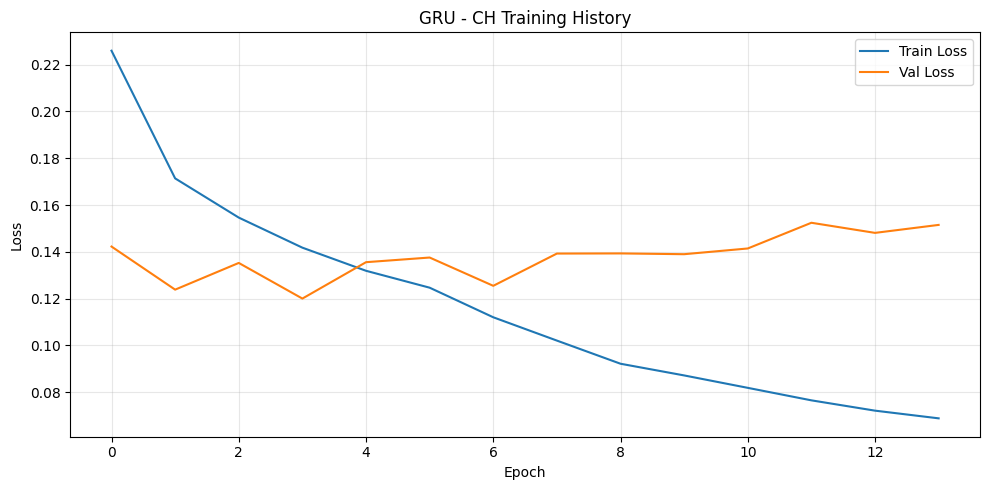

  [CH - GRU] RMSE: 462.36, MAE: 349.30, MAPE: 5.48%
  Anomaly ML - PR-AUC: 0.023, F1@P=0.80: 0.091


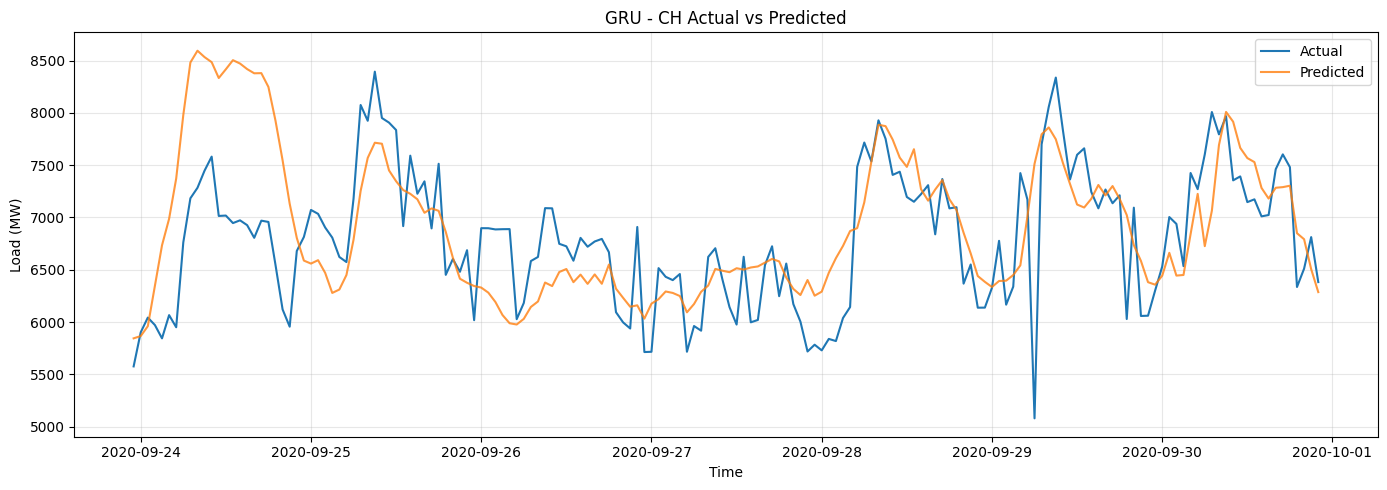


--- Training LSTM for CH ---
Epoch 10/50 - Train Loss: 0.1093, Val Loss: 0.1257
Early stopping at epoch 19


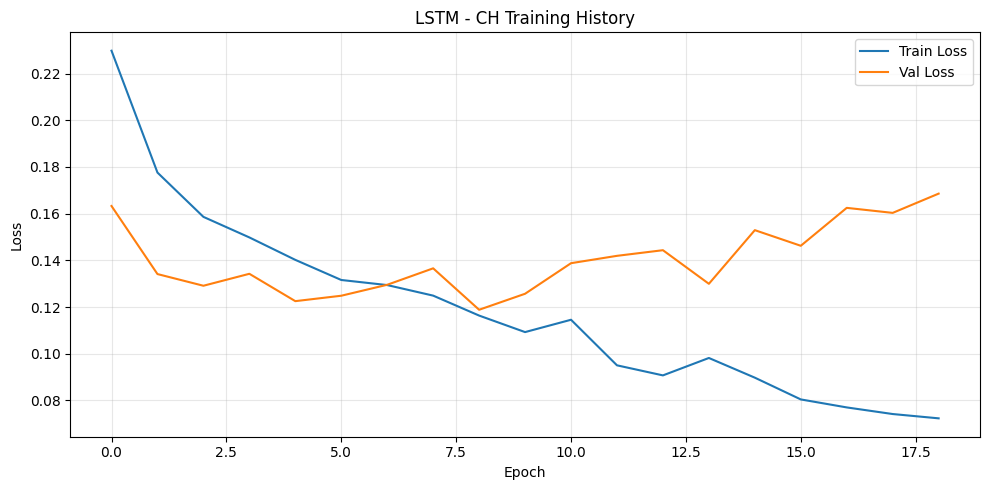

  [CH - LSTM] RMSE: 464.19, MAE: 347.13, MAPE: 5.38%
  Anomaly ML - PR-AUC: 0.033, F1@P=0.80: 0.154


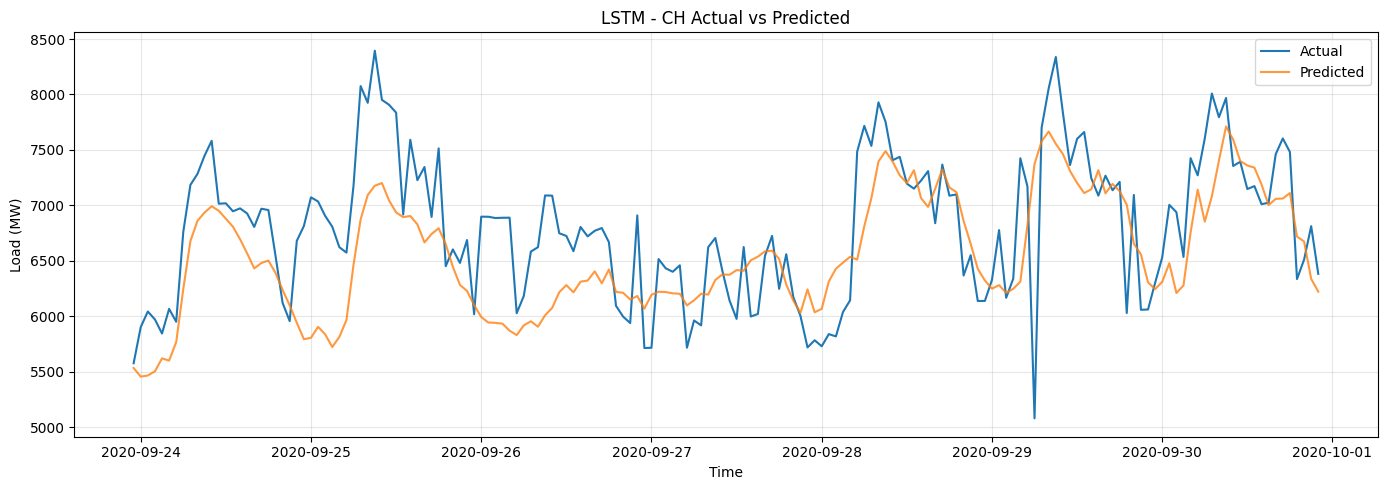


--- Training LSTM_Attention for CH ---
Epoch 10/50 - Train Loss: 0.1286, Val Loss: 0.2639
Early stopping at epoch 16


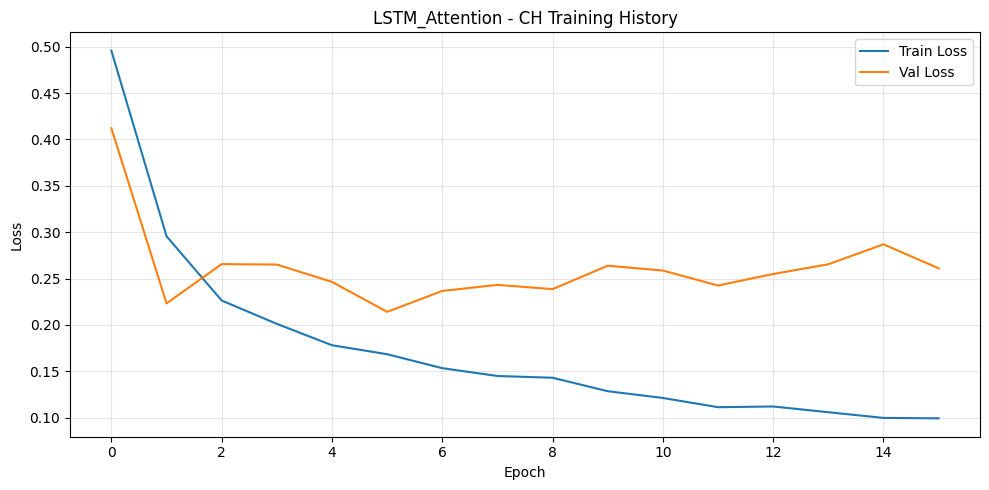

  [CH - LSTM_Attention] RMSE: 563.12, MAE: 438.94, MAPE: 6.77%
  Anomaly ML - PR-AUC: 0.668, F1@P=0.80: 0.667


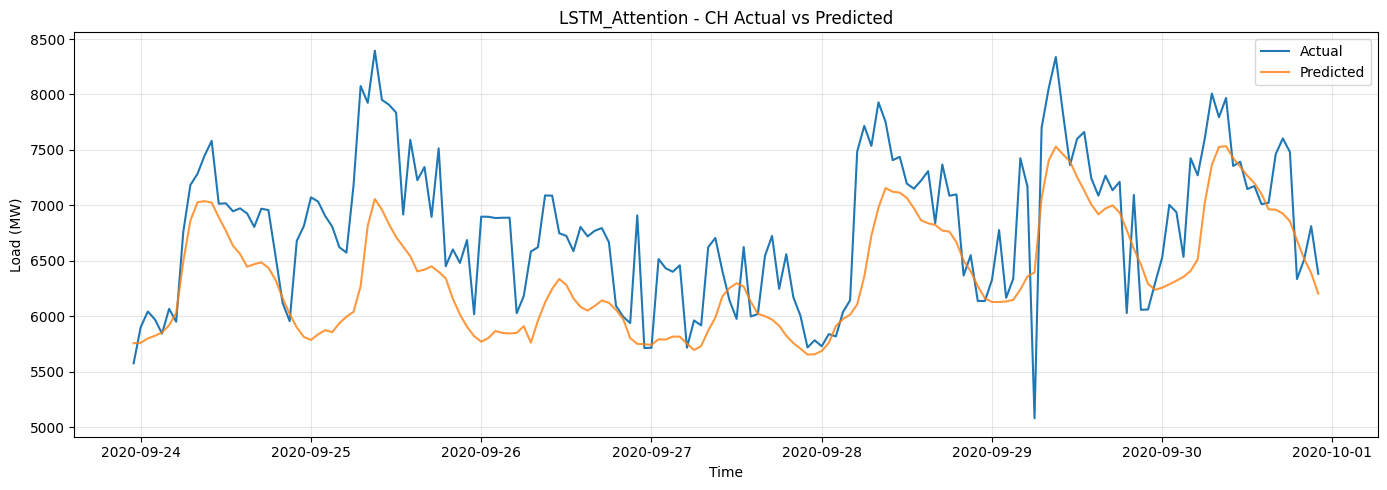


Processing country: FR

Preparing data for FR...
  Shape: (50357, 11)
  Date range: 2015-01-01 01:00:00+00:00 to 2020-09-30 22:00:00+00:00
  Load range: 29398 to 158000
Train: 40285, Val: 5036, Test: 5036
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for FR ---
Epoch 10/50 - Train Loss: 0.0274, Val Loss: 0.0319
Epoch 20/50 - Train Loss: 0.0206, Val Loss: 0.0356
Early stopping at epoch 25


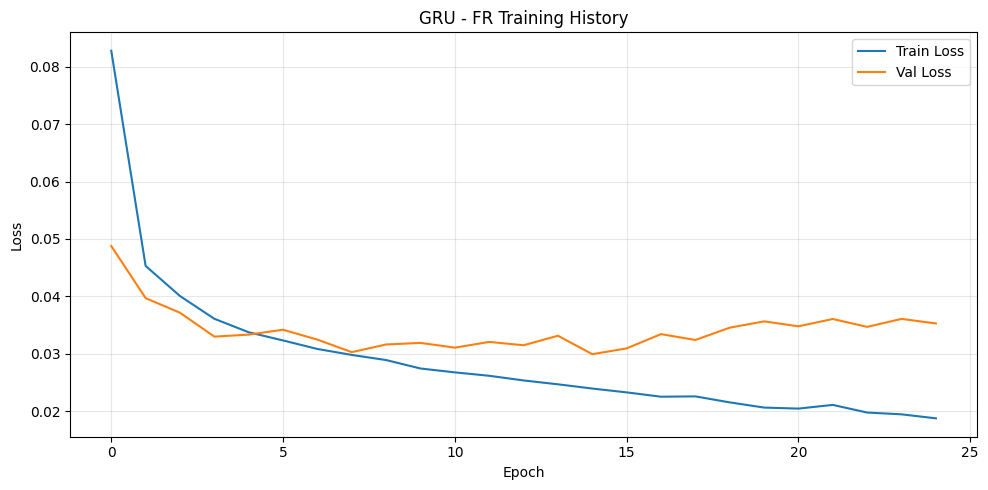

  [FR - GRU] RMSE: 2850.94, MAE: 1856.26, MAPE: 4.38%
  Anomaly ML - PR-AUC: 0.042, F1@P=0.80: 0.154


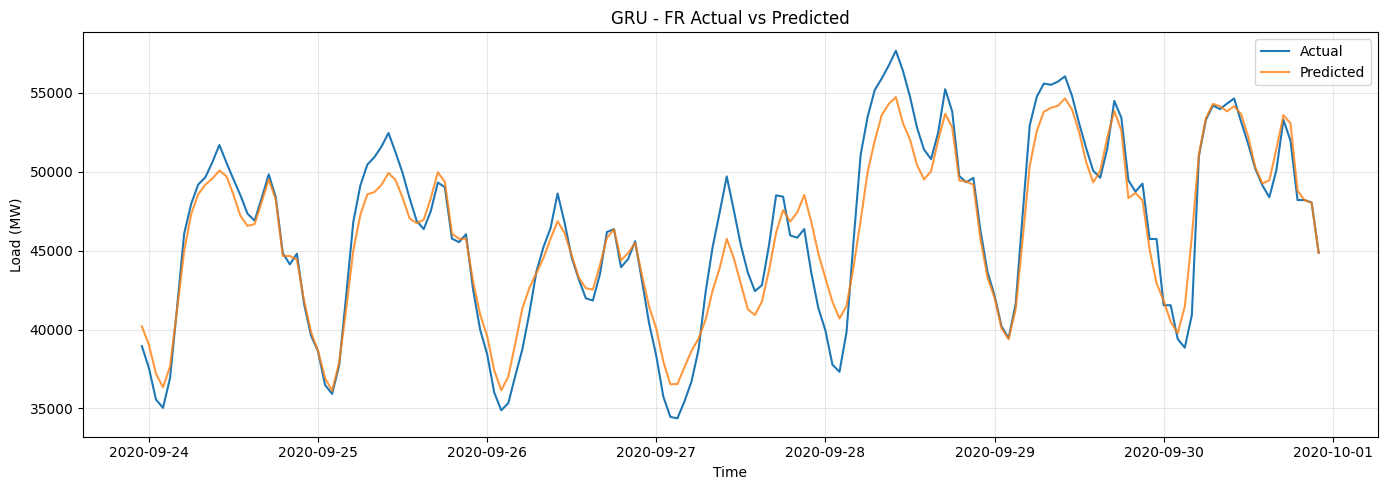


--- Training LSTM for FR ---
Epoch 10/50 - Train Loss: 0.0295, Val Loss: 0.0333
Epoch 20/50 - Train Loss: 0.0244, Val Loss: 0.0292
Epoch 30/50 - Train Loss: 0.0203, Val Loss: 0.0349
Early stopping at epoch 30


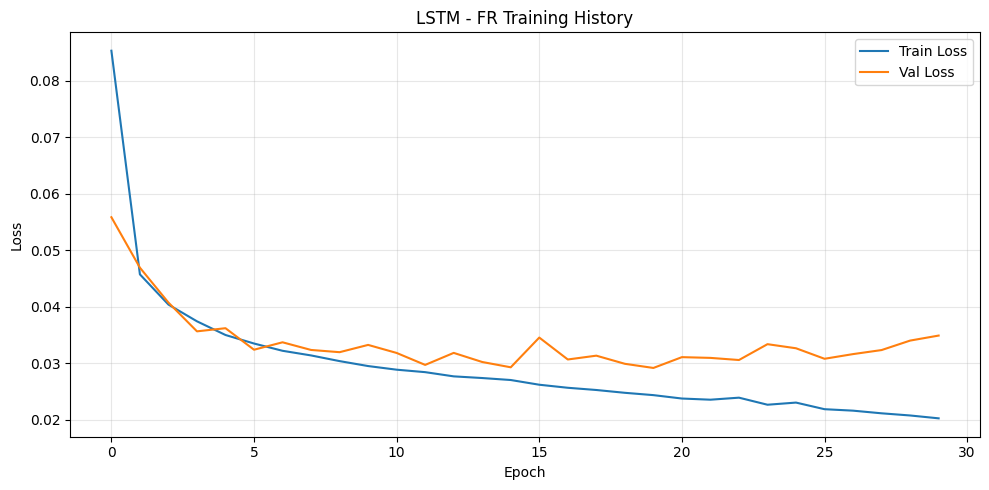

  [FR - LSTM] RMSE: 2915.70, MAE: 1943.99, MAPE: 4.62%
  Anomaly ML - PR-AUC: 0.034, F1@P=0.80: 0.148


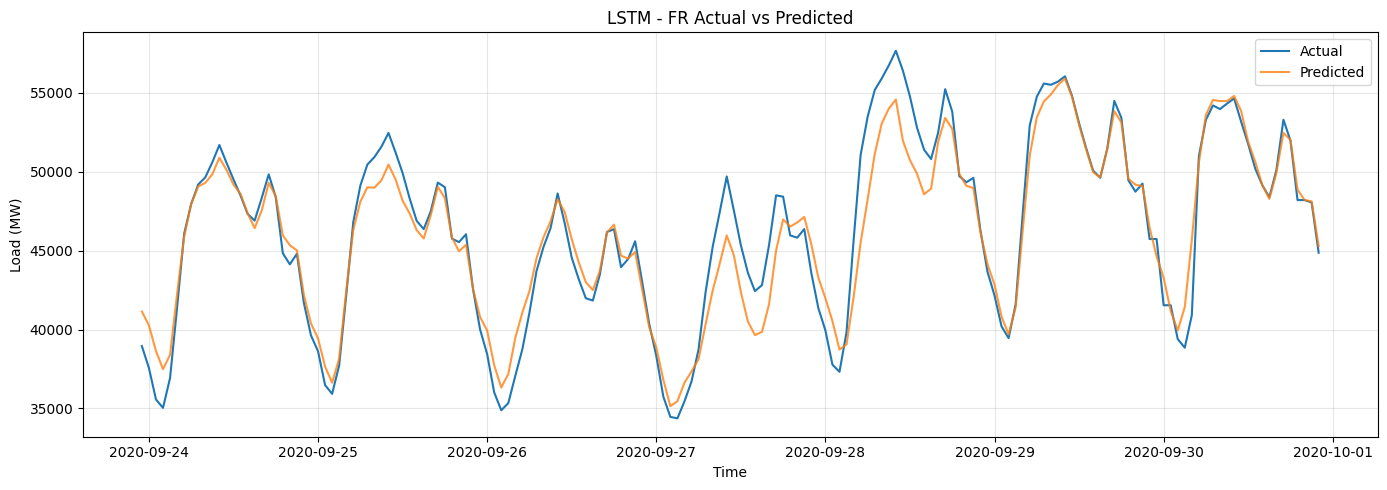


--- Training LSTM_Attention for FR ---
Epoch 10/50 - Train Loss: 0.0479, Val Loss: 0.0682
Epoch 20/50 - Train Loss: 0.0280, Val Loss: 0.0769
Early stopping at epoch 20


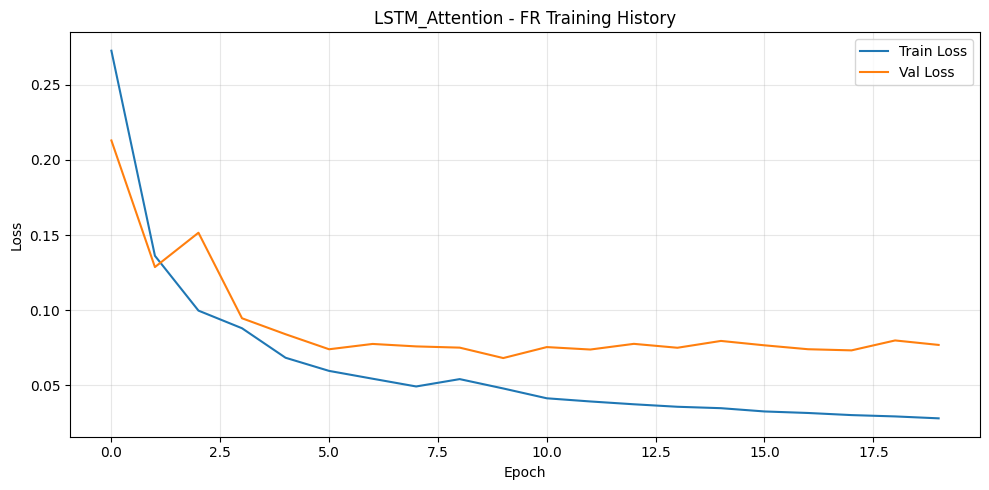

  [FR - LSTM_Attention] RMSE: 3176.02, MAE: 2163.44, MAPE: 4.98%
  Anomaly ML - PR-AUC: 0.667, F1@P=0.80: 0.667


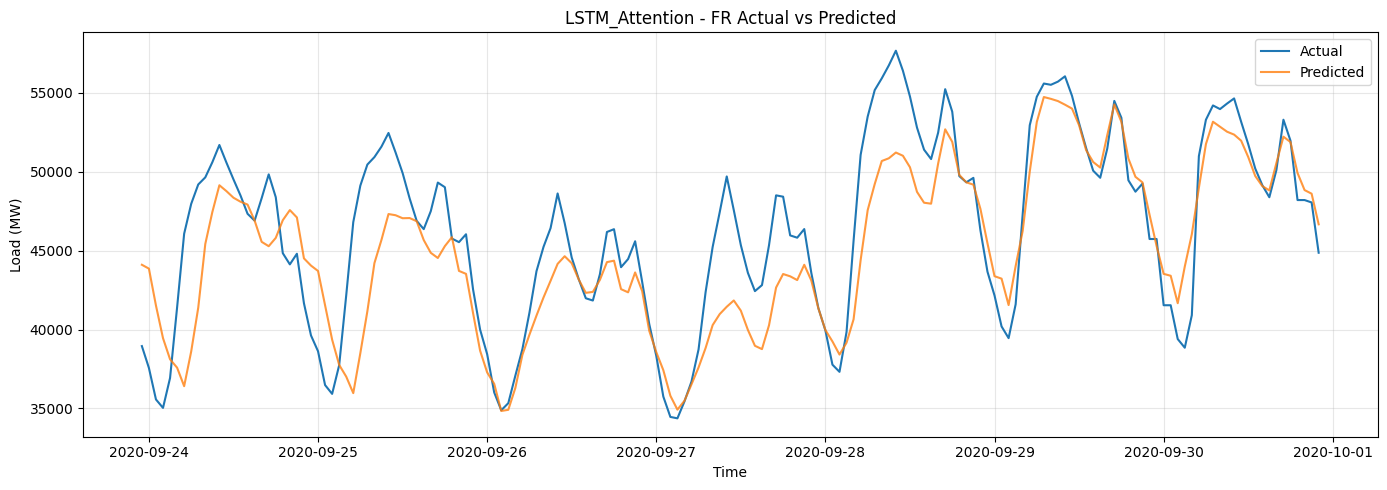


Processing country: AT

Preparing data for AT...
  Shape: (50400, 11)
  Date range: 2015-01-01 00:00:00+00:00 to 2020-09-30 23:00:00+00:00
  Load range: 664 to 10803
Train: 40320, Val: 5040, Test: 5040
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for AT ---
Epoch 10/50 - Train Loss: 0.0564, Val Loss: 0.0433
Epoch 20/50 - Train Loss: 0.0352, Val Loss: 0.0461
Early stopping at epoch 28


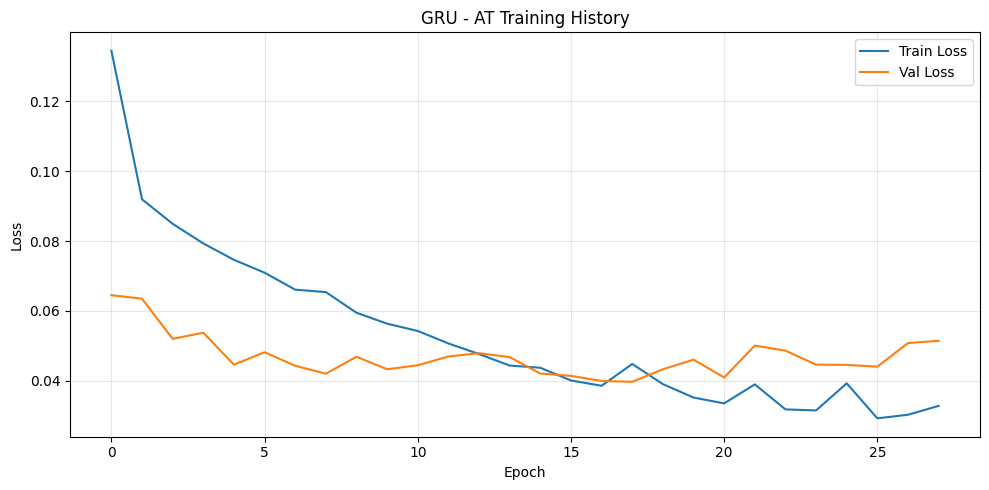

  [AT - GRU] RMSE: 347.93, MAE: 232.17, MAPE: 3.62%
  Anomaly ML - PR-AUC: 0.155, F1@P=0.80: 0.190


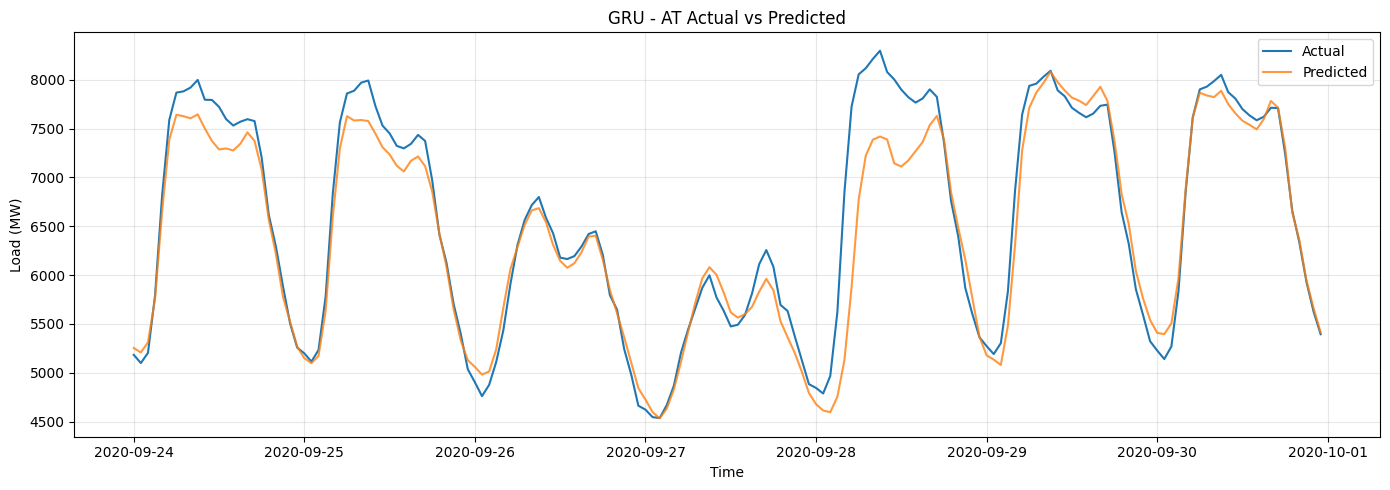


--- Training LSTM for AT ---
Epoch 10/50 - Train Loss: 0.0625, Val Loss: 0.0491
Epoch 20/50 - Train Loss: 0.0456, Val Loss: 0.0603
Early stopping at epoch 20


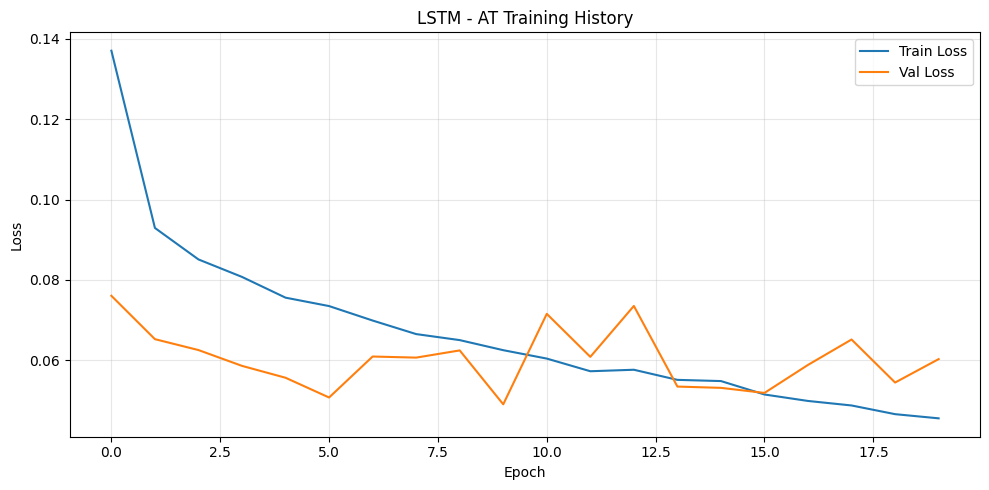

  [AT - LSTM] RMSE: 312.22, MAE: 213.55, MAPE: 3.35%
  Anomaly ML - PR-AUC: 0.524, F1@P=0.80: 0.400


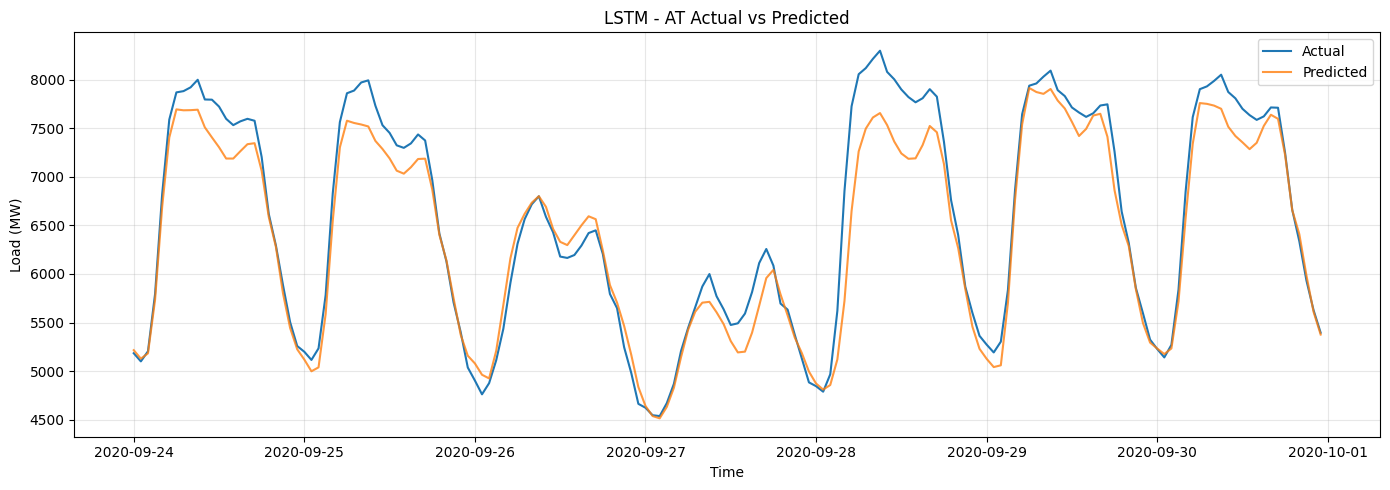


--- Training LSTM_Attention for AT ---
Epoch 10/50 - Train Loss: 0.0773, Val Loss: 0.0812
Early stopping at epoch 18


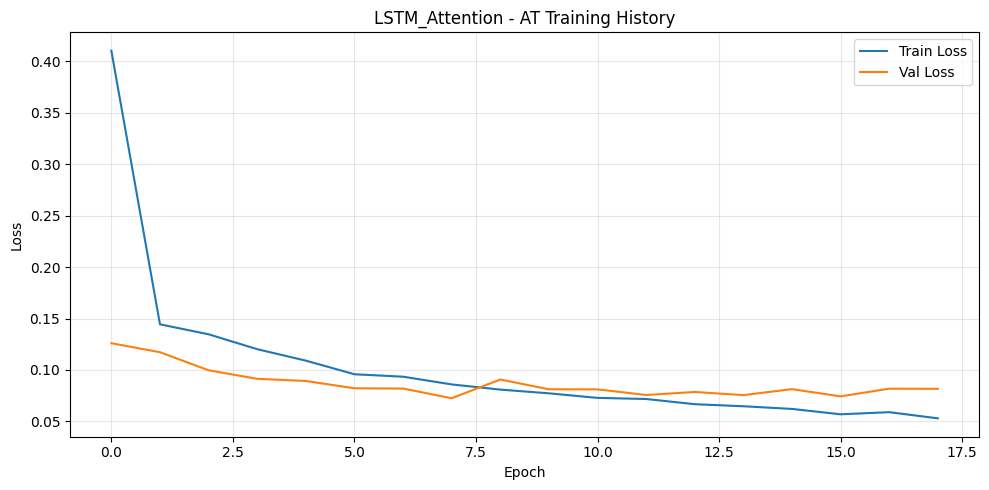

  [AT - LSTM_Attention] RMSE: 382.09, MAE: 276.05, MAPE: 4.36%
  Anomaly ML - PR-AUC: 0.350, F1@P=0.80: 0.444


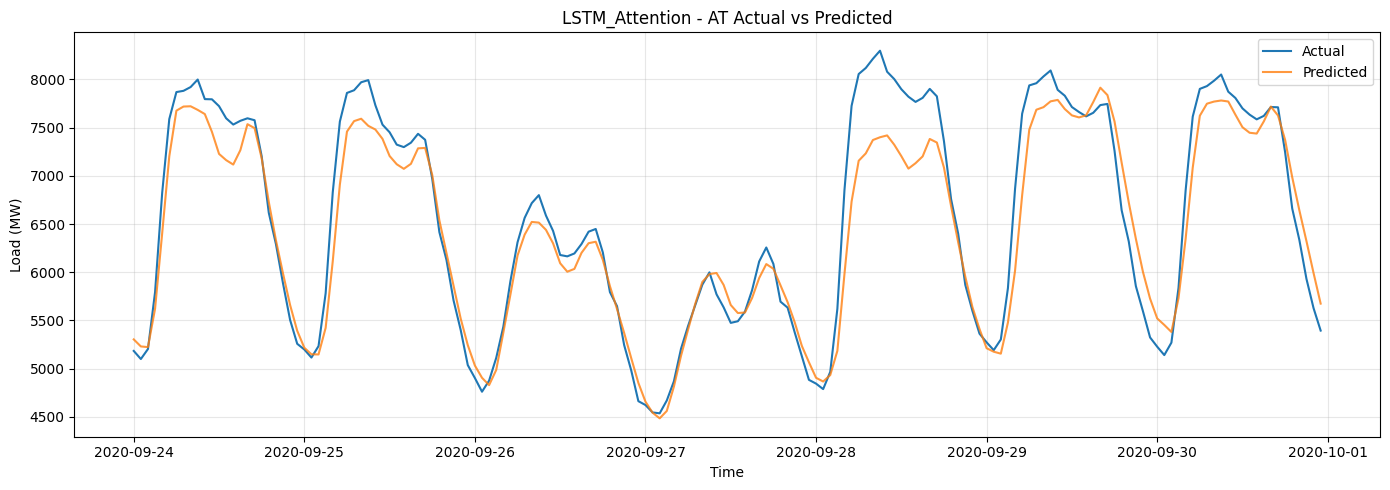


==================== MODEL DASHBOARD SUMMARY ====================
  country           model           MSE         RMSE          MAE      MAPE  \
0      CH             GRU  2.137812e+05   462.364772   349.298089  5.478556   
1      CH            LSTM  2.154699e+05   464.187402   347.126697  5.379438   
2      CH  LSTM_Attention  3.171041e+05   563.120000   438.942846  6.769158   
3      FR             GRU  8.127884e+06  2850.944318  1856.257947  4.381703   
4      FR            LSTM  8.501306e+06  2915.699909  1943.994770  4.619351   
5      FR  LSTM_Attention  1.008708e+07  3176.016873  2163.441401  4.981100   
6      AT             GRU  1.210542e+05   347.928372   232.172900  3.623515   
7      AT            LSTM  9.748254e+04   312.221945   213.545904  3.347117   
8      AT  LSTM_Attention  1.459907e+05   382.087266   276.047579  4.363802   

      sMAPE      MASE    PR_AUC  F1_at_P80  
0  5.484016  1.554937  0.023450   0.090909  
1  5.446160  1.545271  0.032553   0.153846  
2  6.89

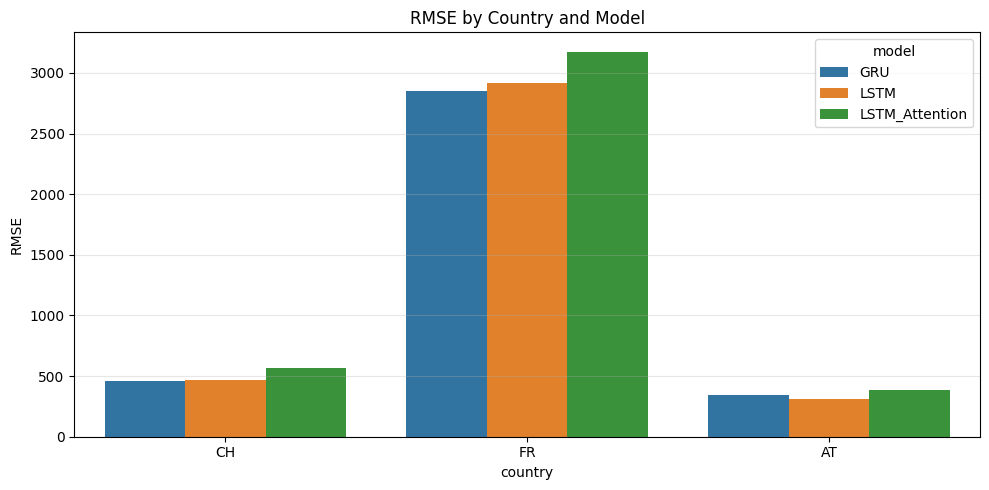

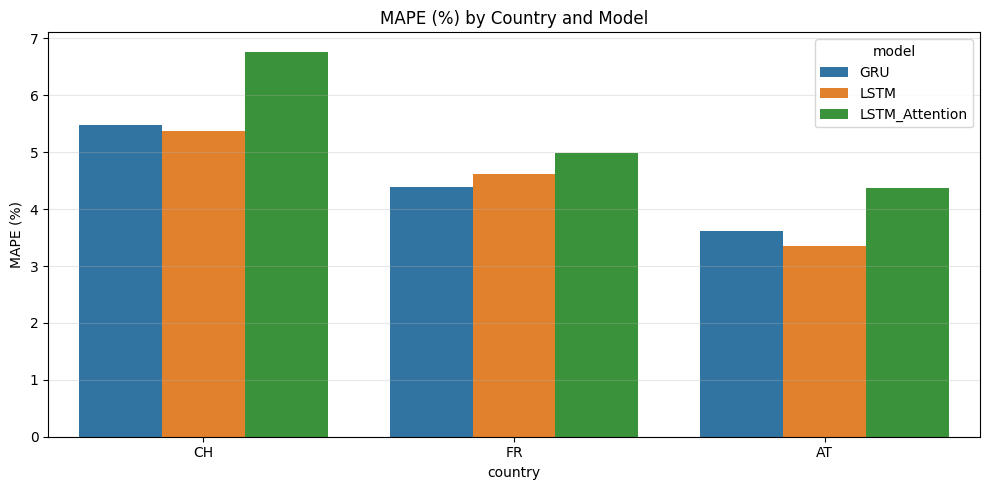

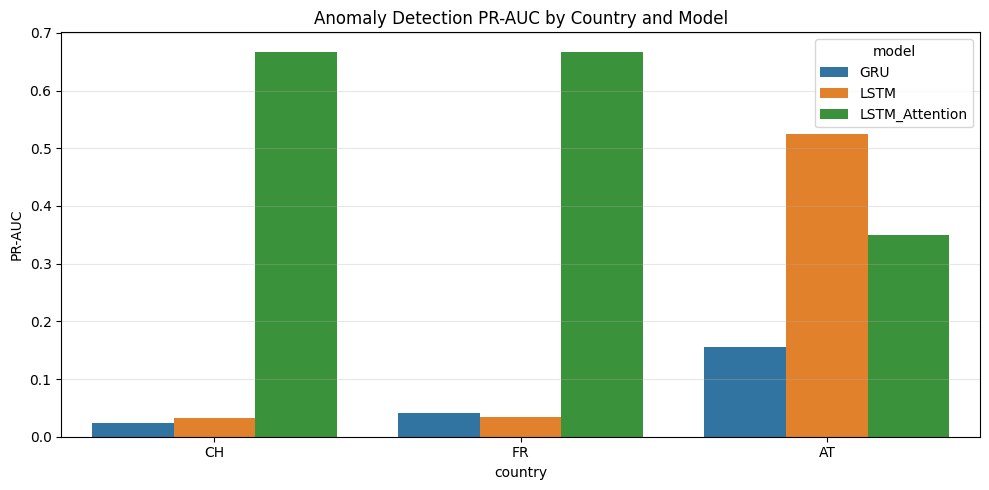

In [ ]:

def run_pipeline():
    """
    Run the complete pipeline:
      - Download / generate data
      - Train GRU / LSTM / LSTM+Attention for each country
      - Evaluate + anomaly detection
      - Build dashboard summary
    """
    df_raw = download_opsd_data()
    all_results = {}

    for country in CONFIG["countries"]:
        country_results = run_country_experiments(df_raw, country)
        all_results[country] = country_results

    dashboard_df = build_dashboard(all_results)
    return all_results, dashboard_df


if __name__ == "__main__":
    # Running this file as a script will execute the full pipeline.
    all_results, dashboard_df = run_pipeline()

Downloaded data shape: (50401, 300)

Processing country: CH

Preparing data for CH...
  Shape: (50398, 11)
  Date range: 2015-01-01 01:00:00+00:00 to 2020-09-30 22:00:00+00:00
  Load range: 1483 to 18544
Train: 40318, Val: 5040, Test: 5040
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for CH ---
Epoch 10/50 - Train Loss: 0.0912, Val Loss: 0.1345
Early stopping at epoch 14


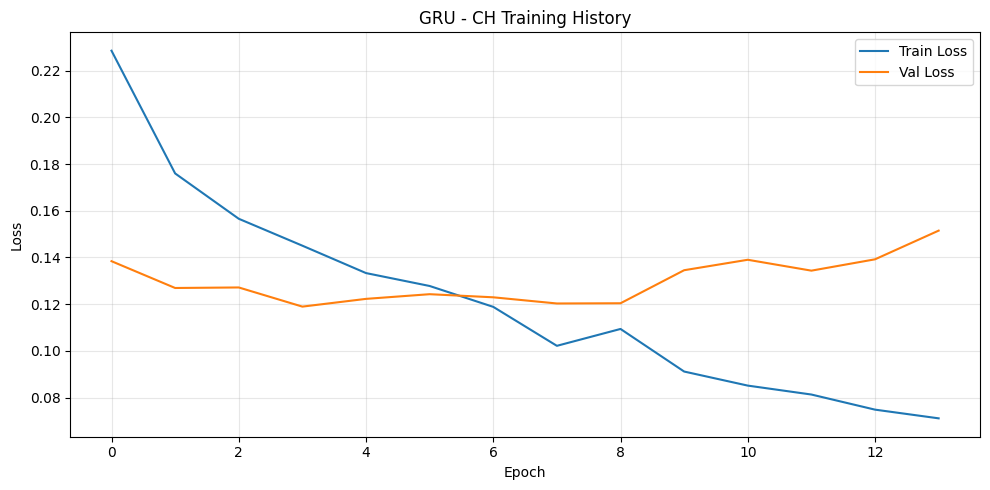

  [CH - GRU] RMSE: 459.71, MAE: 349.33, MAPE: 5.45%
  Anomaly ML - PR-AUC: 0.020, F1@P=0.80: 0.182


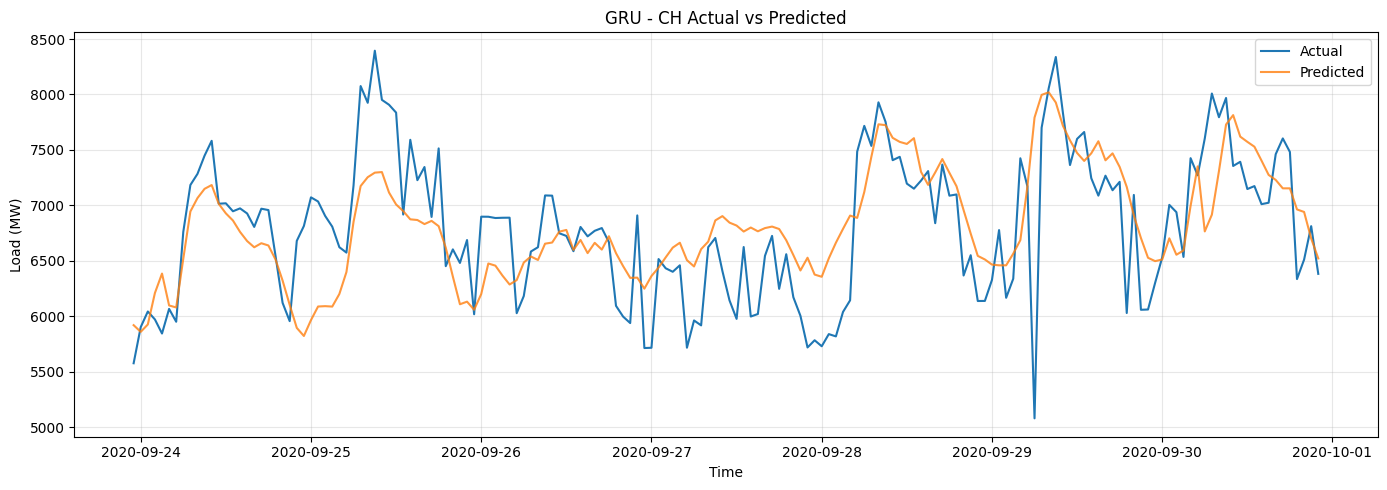


--- Training LSTM for CH ---
Epoch 10/50 - Train Loss: 0.1191, Val Loss: 0.1408
Early stopping at epoch 16


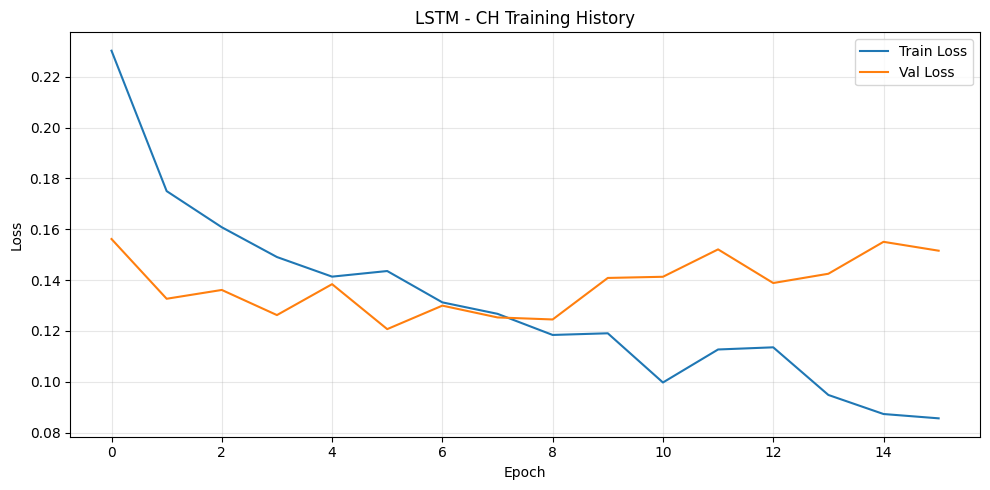

  [CH - LSTM] RMSE: 449.85, MAE: 341.95, MAPE: 5.31%
  Anomaly ML - PR-AUC: 0.076, F1@P=0.80: 0.333


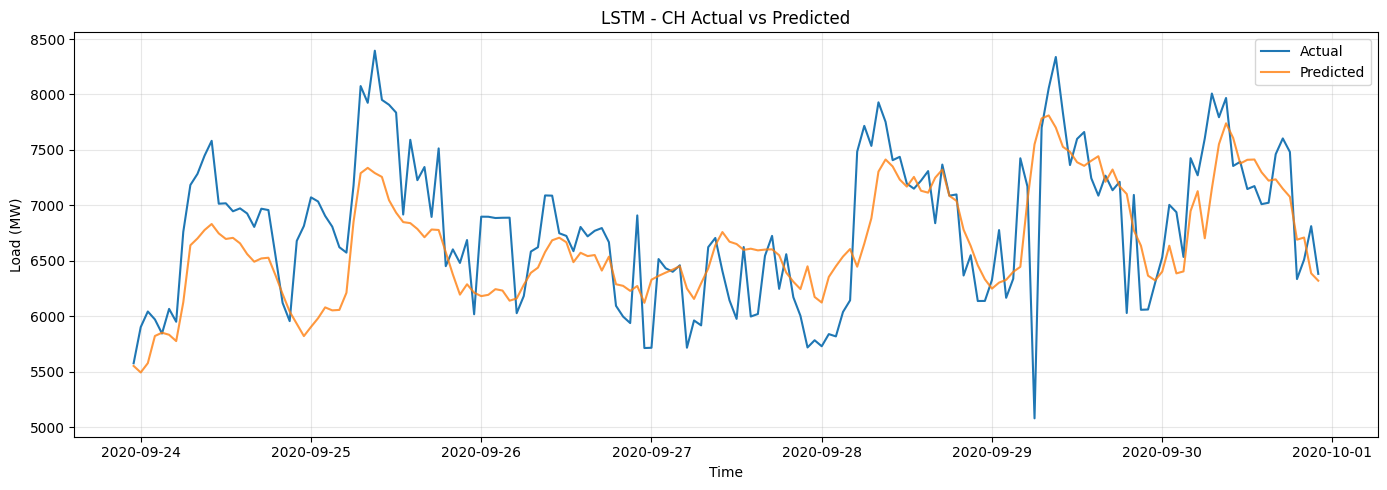


--- Training LSTM_Attention for CH ---
Epoch 10/50 - Train Loss: 0.1312, Val Loss: 0.2546
Early stopping at epoch 15


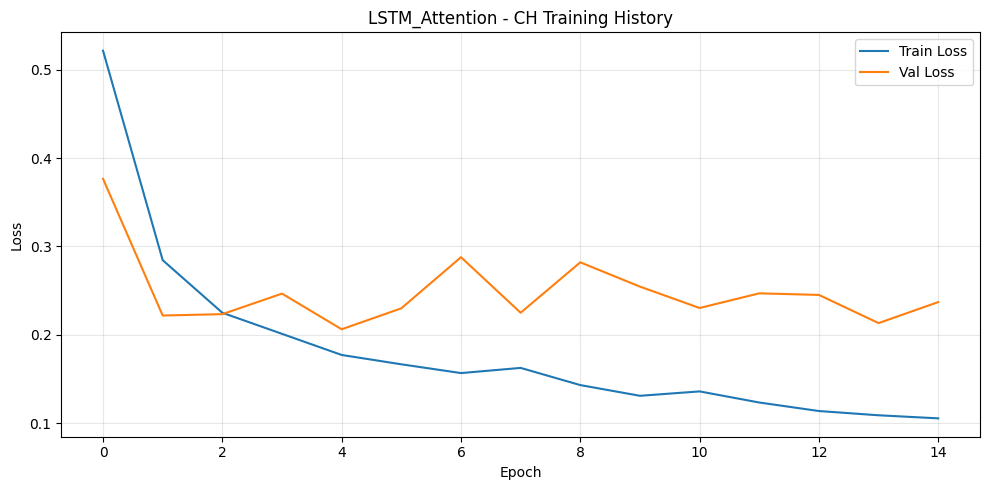

  [CH - LSTM_Attention] RMSE: 534.22, MAE: 424.37, MAPE: 6.54%
  Anomaly ML - PR-AUC: 0.426, F1@P=0.80: 0.333


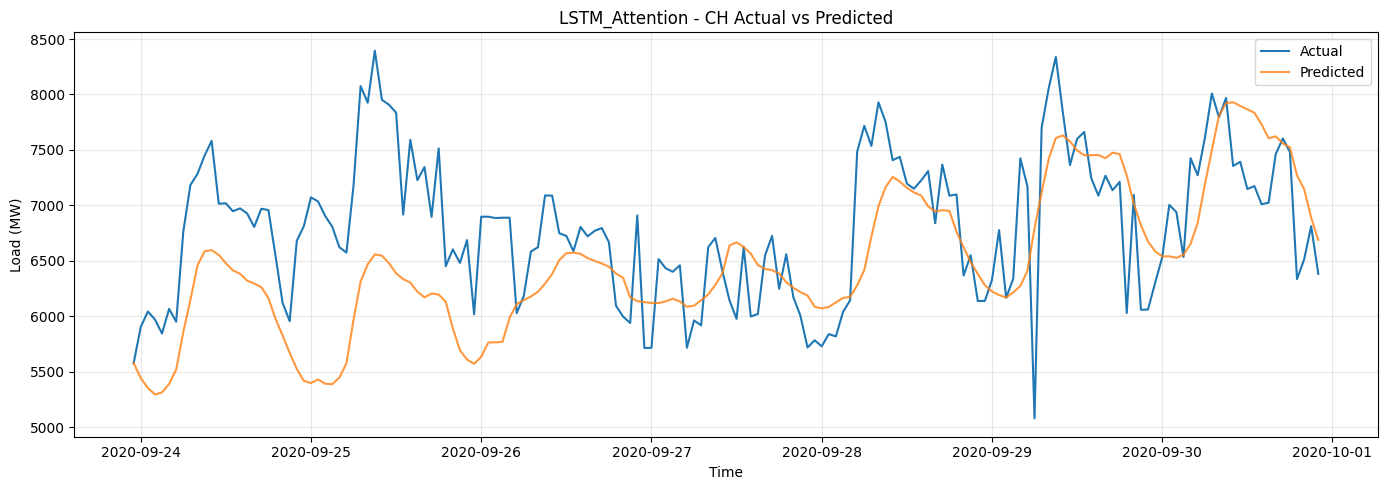


Processing country: FR

Preparing data for FR...
  Shape: (50357, 11)
  Date range: 2015-01-01 01:00:00+00:00 to 2020-09-30 22:00:00+00:00
  Load range: 29398 to 158000
Train: 40285, Val: 5036, Test: 5036
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for FR ---
Epoch 10/50 - Train Loss: 0.0284, Val Loss: 0.0299
Epoch 20/50 - Train Loss: 0.0215, Val Loss: 0.0346
Early stopping at epoch 22


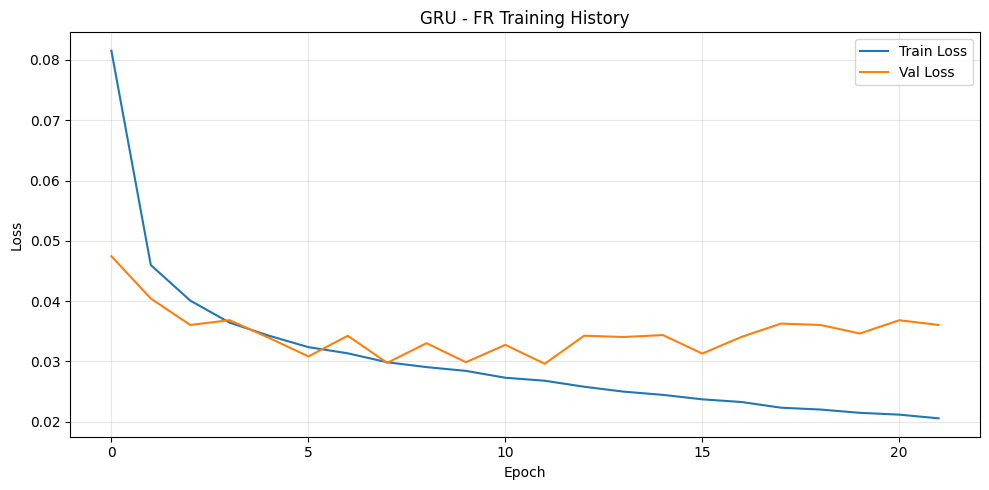

  [FR - GRU] RMSE: 2856.06, MAE: 1855.54, MAPE: 4.39%
  Anomaly ML - PR-AUC: 0.270, F1@P=0.80: 0.444


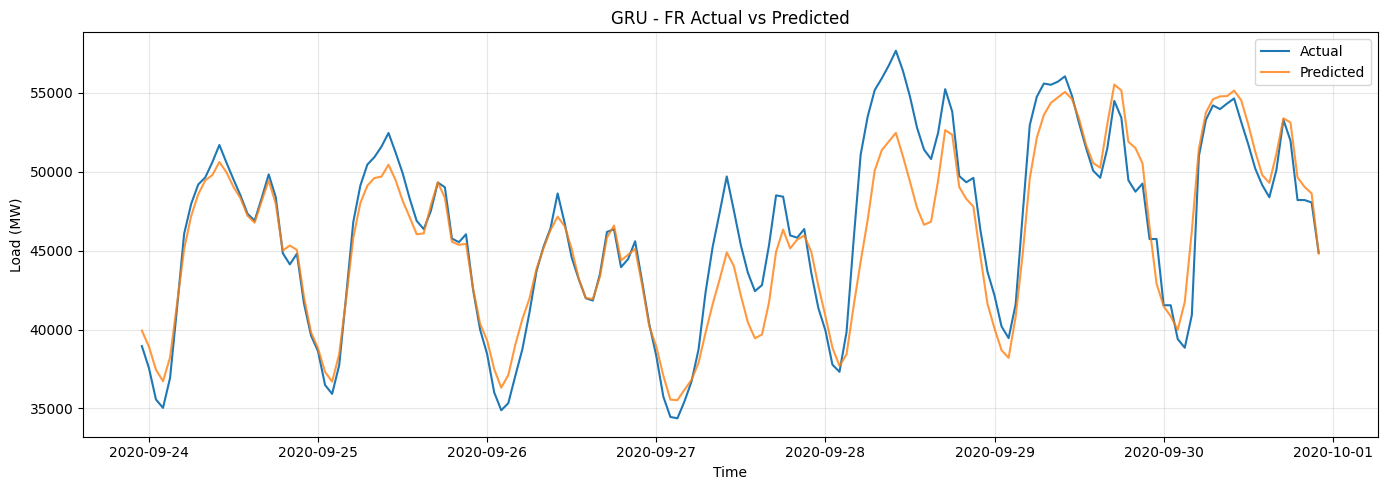


--- Training LSTM for FR ---
Epoch 10/50 - Train Loss: 0.0306, Val Loss: 0.0314
Epoch 20/50 - Train Loss: 0.0244, Val Loss: 0.0303
Early stopping at epoch 22


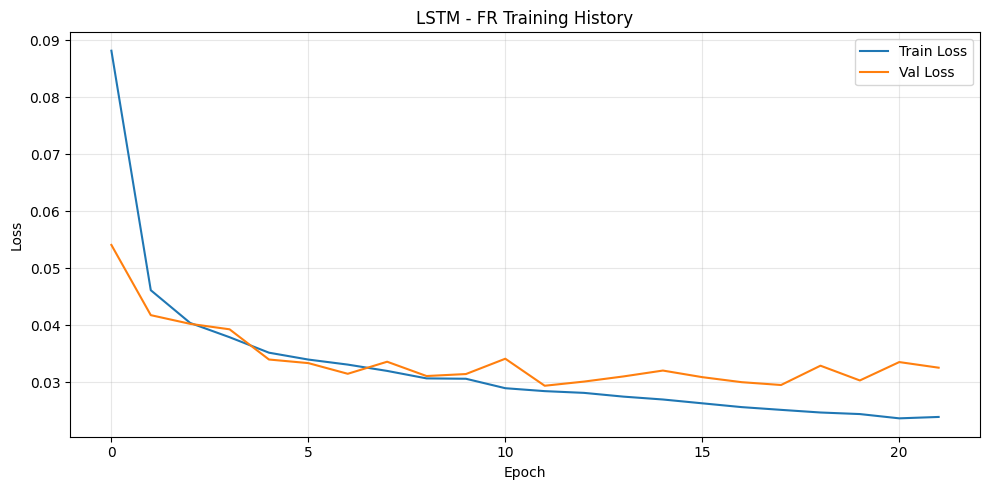

  [FR - LSTM] RMSE: 2803.81, MAE: 1833.67, MAPE: 4.32%
  Anomaly ML - PR-AUC: 0.017, F1@P=0.80: 0.058


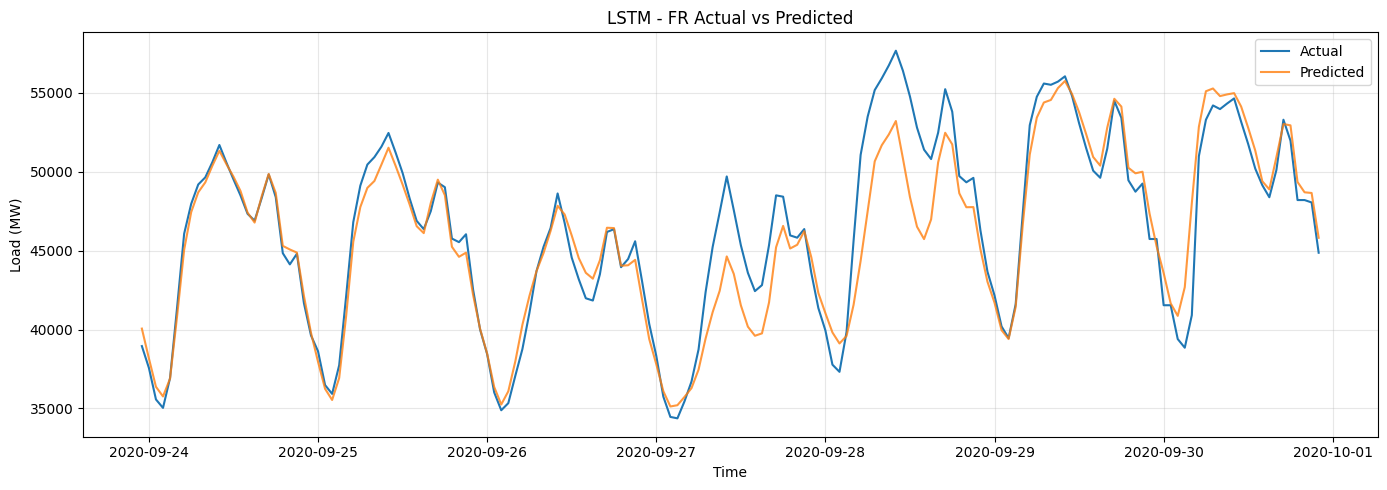


--- Training LSTM_Attention for FR ---
Epoch 10/50 - Train Loss: 0.0441, Val Loss: 0.0778
Epoch 20/50 - Train Loss: 0.0279, Val Loss: 0.0804
Early stopping at epoch 22


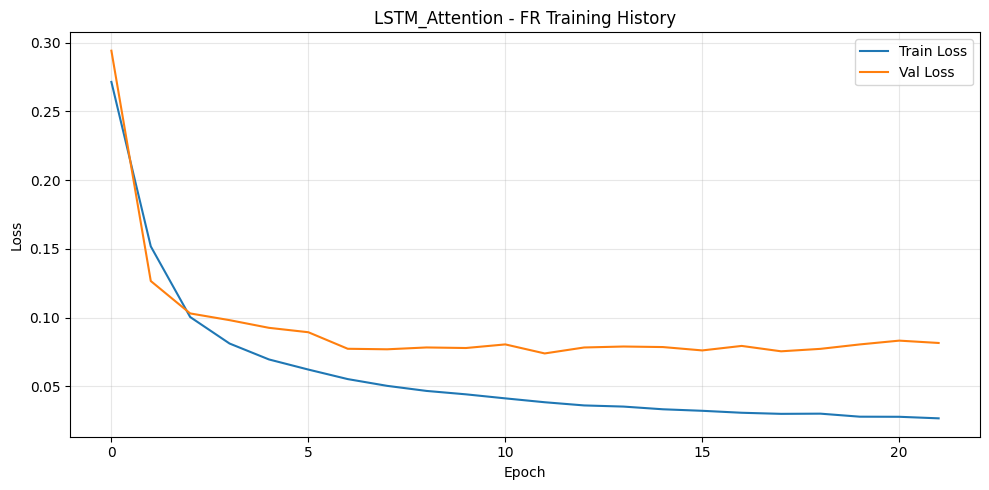

  [FR - LSTM_Attention] RMSE: 3224.56, MAE: 2248.14, MAPE: 5.29%
  Anomaly ML - PR-AUC: 0.473, F1@P=0.80: 0.500


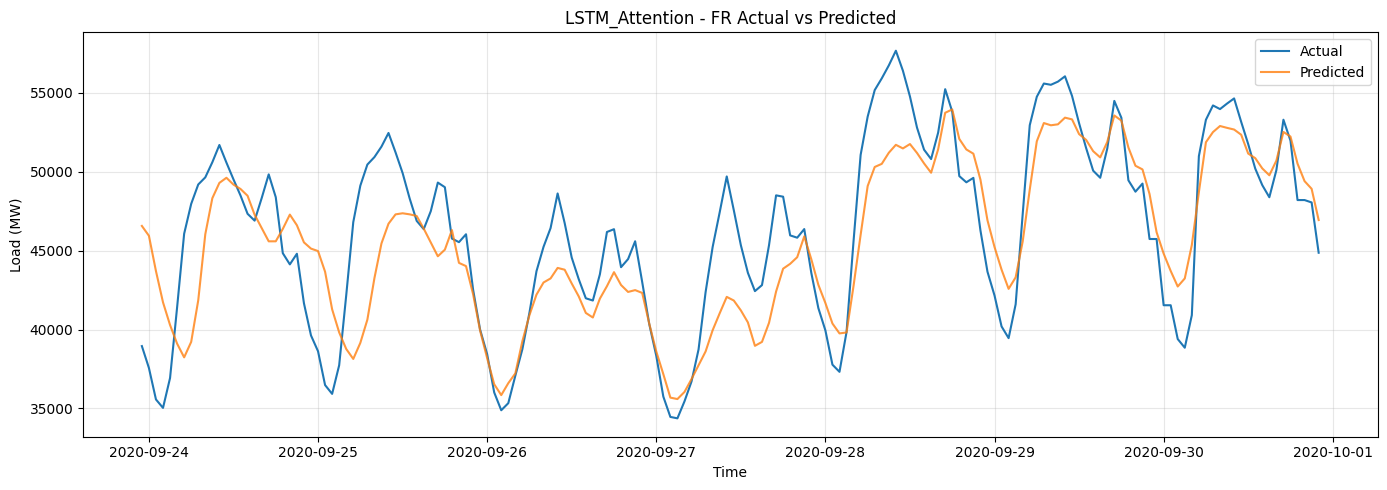


Processing country: AT

Preparing data for AT...
  Shape: (50400, 11)
  Date range: 2015-01-01 00:00:00+00:00 to 2020-09-30 23:00:00+00:00
  Load range: 664 to 10803
Train: 40320, Val: 5040, Test: 5040
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for AT ---
Epoch 10/50 - Train Loss: 0.0588, Val Loss: 0.0687
Early stopping at epoch 14


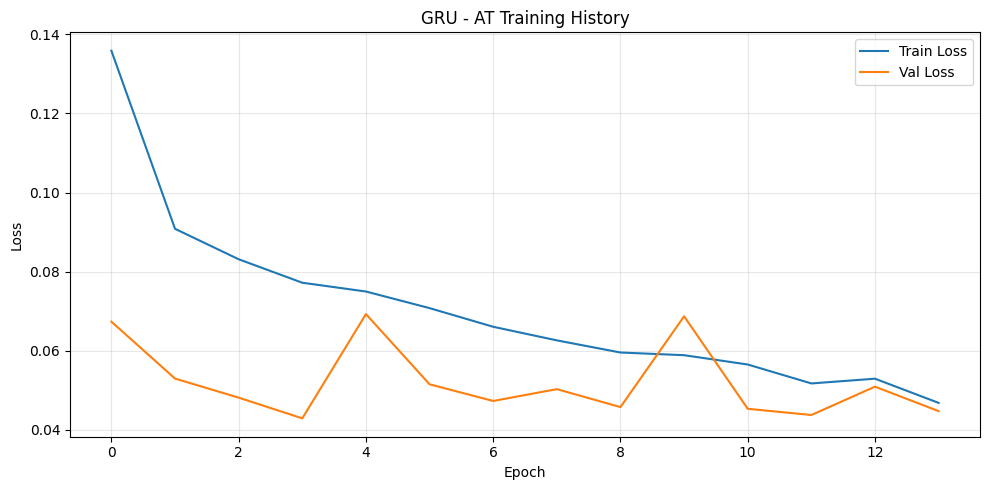

  [AT - GRU] RMSE: 385.15, MAE: 255.06, MAPE: 3.95%
  Anomaly ML - PR-AUC: 0.087, F1@P=0.80: 0.140


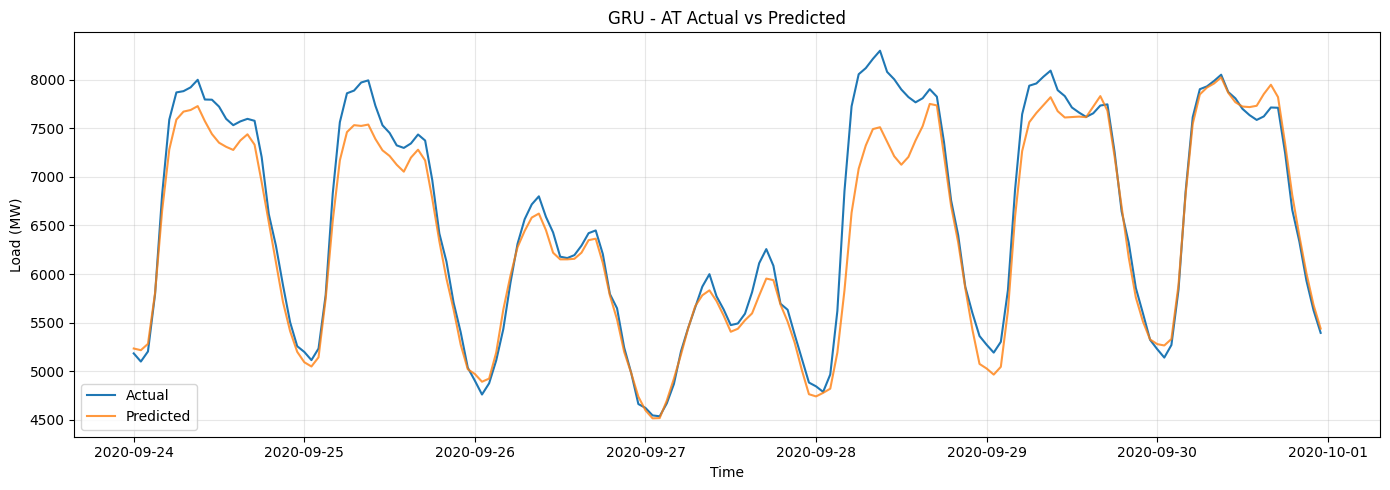


--- Training LSTM for AT ---
Epoch 10/50 - Train Loss: 0.0618, Val Loss: 0.0534
Early stopping at epoch 16


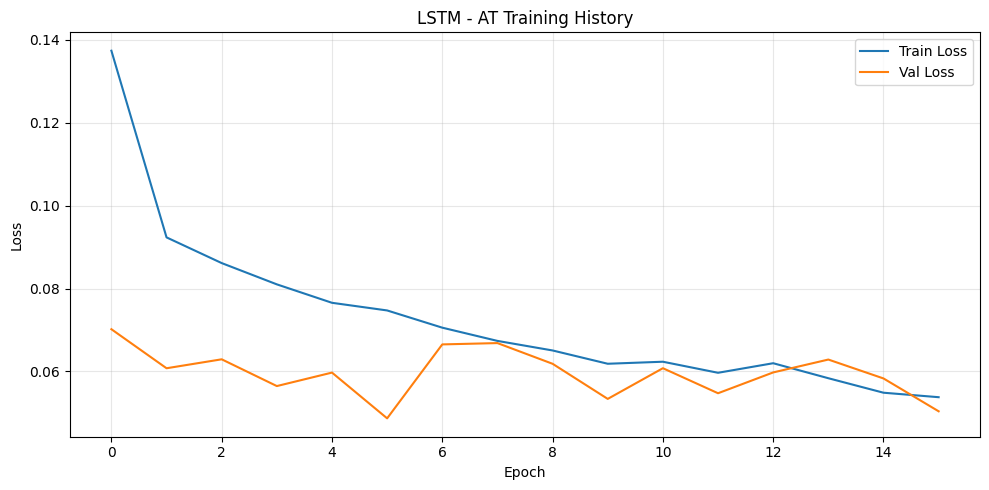

  [AT - LSTM] RMSE: 305.53, MAE: 206.17, MAPE: 3.27%
  Anomaly ML - PR-AUC: 0.413, F1@P=0.80: 0.552


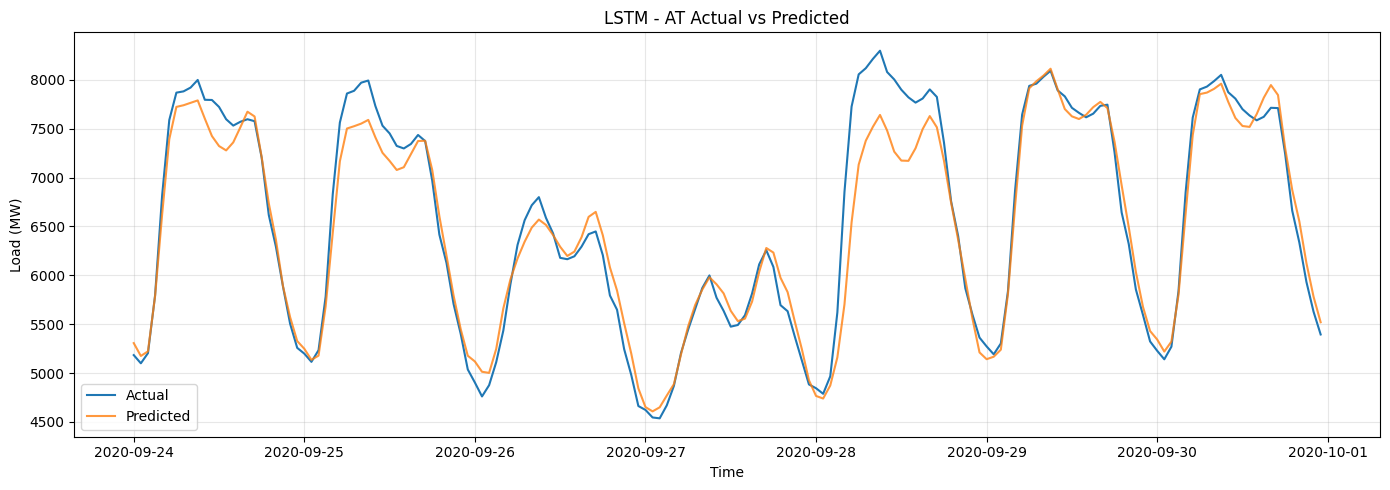


--- Training LSTM_Attention for AT ---
Epoch 10/50 - Train Loss: 0.0854, Val Loss: 0.0842
Epoch 20/50 - Train Loss: 0.0580, Val Loss: 0.0772
Epoch 30/50 - Train Loss: 0.0473, Val Loss: 0.0785
Early stopping at epoch 38


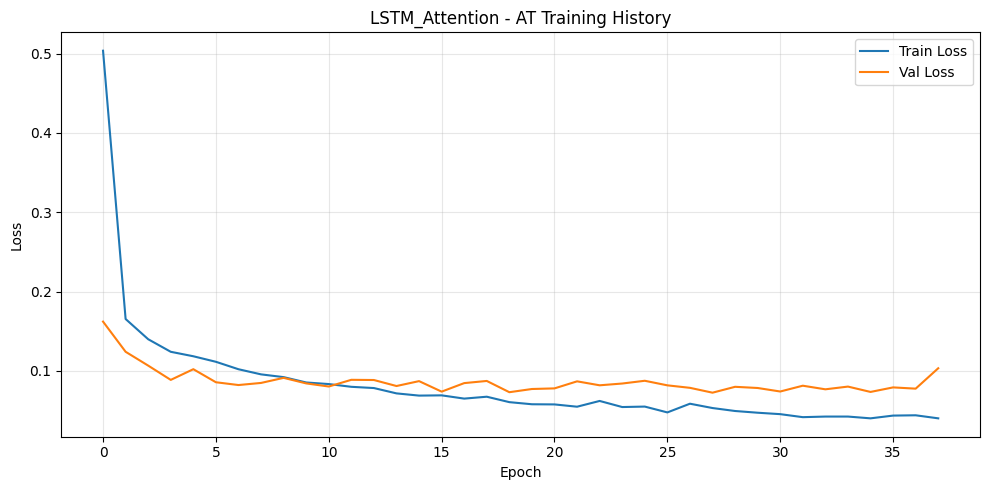

  [AT - LSTM_Attention] RMSE: 367.12, MAE: 261.25, MAPE: 4.23%
  Anomaly ML - PR-AUC: 0.259, F1@P=0.80: 0.261


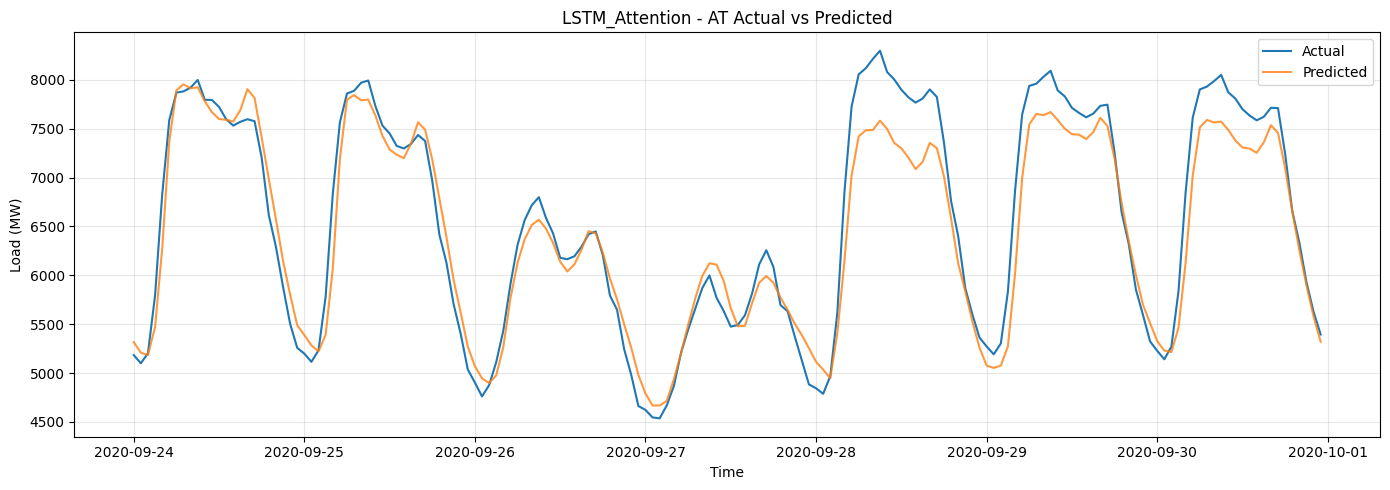


==================== MODEL DASHBOARD SUMMARY ====================
  country           model           MSE         RMSE          MAE      MAPE  \
0      CH             GRU  2.113369e+05   459.713893   349.328788  5.448577   
1      CH            LSTM  2.023637e+05   449.848532   341.953950  5.309474   
2      CH  LSTM_Attention  2.853880e+05   534.217171   424.373233  6.537593   
3      FR             GRU  8.157096e+06  2856.063024  1855.541782  4.385054   
4      FR            LSTM  7.861360e+06  2803.811724  1833.670960  4.319422   
5      FR  LSTM_Attention  1.039778e+07  3224.558320  2248.135662  5.286586   
6      AT             GRU  1.483368e+05   385.145225   255.055633  3.949689   
7      AT            LSTM  9.334813e+04   305.529266   206.170567  3.265131   
8      AT  LSTM_Attention  1.347754e+05   367.117639   261.253661  4.228313   

      sMAPE      MASE    PR_AUC  F1_at_P80  
0  5.487453  1.555074  0.019844   0.181818  
1  5.357238  1.522244  0.075747   0.333333  
2  6.66

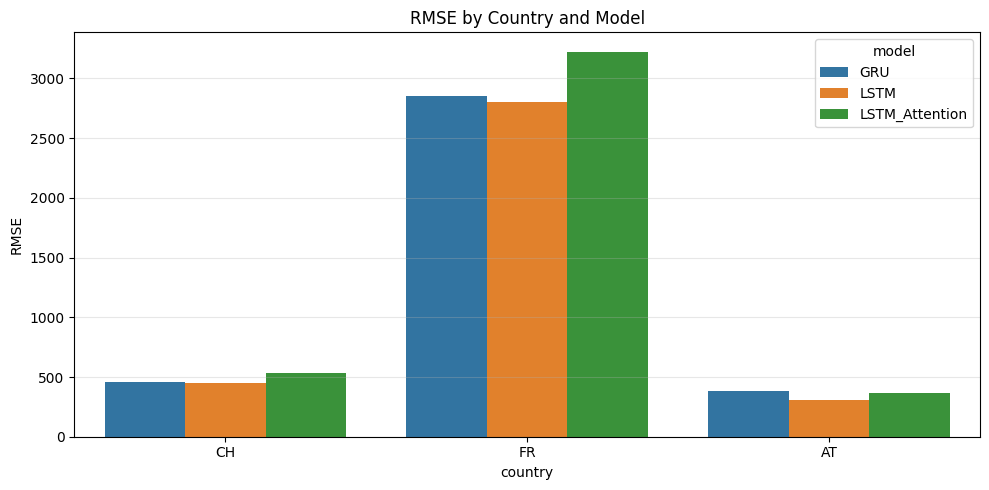

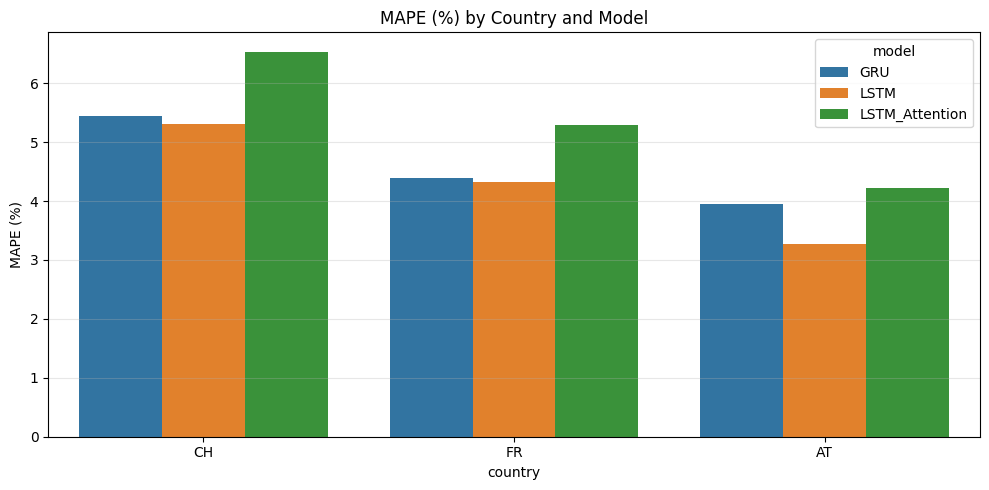

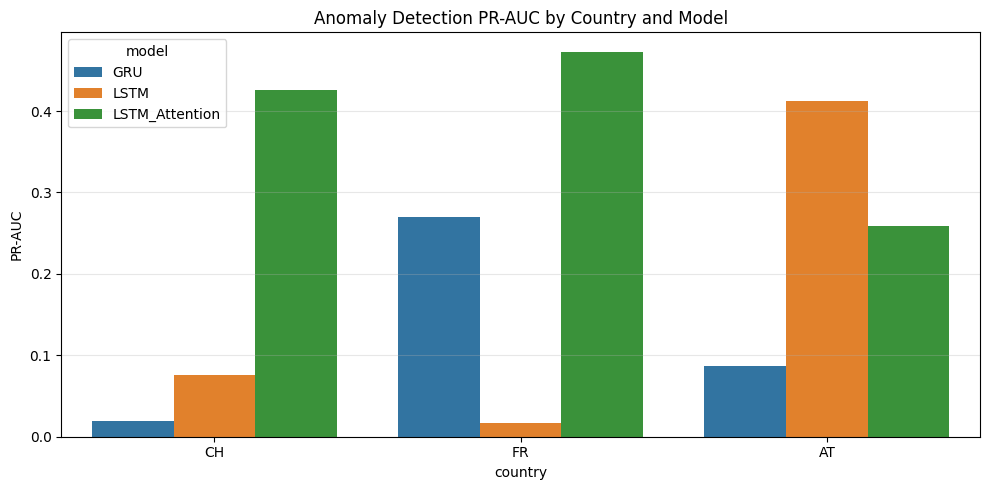

Saved dashboard summary to: artifacts/dashboard_summary.csv
Saved full results (including models) to: artifacts/all_results.pkl


In [ ]:
import joblib

def save_artifacts(all_results, dashboard_df, out_dir="artifacts"):
    os.makedirs(out_dir, exist_ok=True)

    # Save metrics table for Streamlit
    csv_path = os.path.join(out_dir, "dashboard_summary.csv")
    dashboard_df.to_csv(csv_path, index=False)
    print(f"Saved dashboard summary to: {csv_path}")

    # Optionally save full results (models + metrics) via joblib
    pkl_path = os.path.join(out_dir, "all_results.pkl")
    joblib.dump(all_results, pkl_path)
    print(f"Saved full results (including models) to: {pkl_path}")


if __name__ == "__main__":
    # Running this file as a script will execute the full pipeline.
    all_results, dashboard_df = run_pipeline()

    # Save for later use in Streamlit
    save_artifacts(all_results, dashboard_df)


Starting pipeline...
Downloaded data shape: (50401, 300)

Processing country: CH

Preparing data for CH...
  Shape: (50398, 11)
  Date range: 2015-01-01 01:00:00+00:00 to 2020-09-30 22:00:00+00:00
  Load range: 1483 to 18544
Train: 40318, Val: 5040, Test: 5040
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for CH ---
Epoch 10/50 - Train Loss: 0.0890, Val Loss: 0.1421
Early stopping at epoch 16


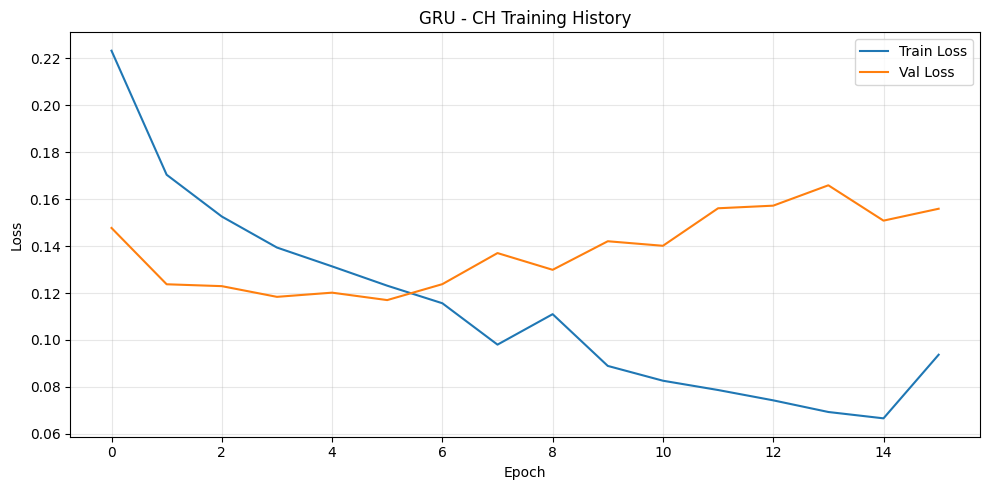

  [CH - GRU] RMSE: 489.69, MAE: 359.31, MAPE: 5.64%
  Anomaly ML - PR-AUC: 0.049, F1@P=0.80: 0.154


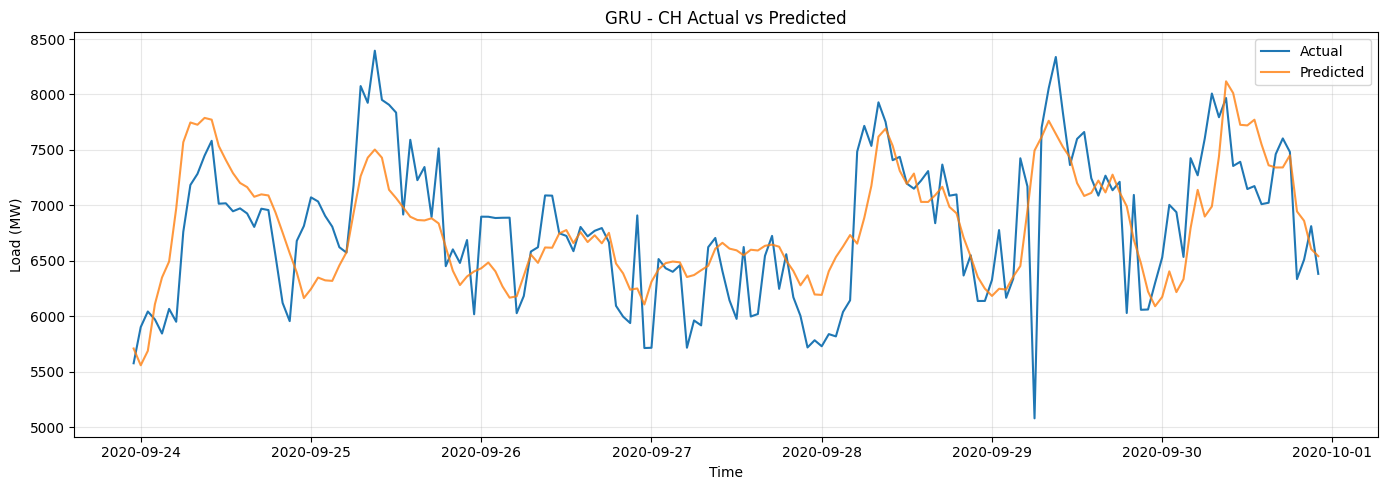


--- Training LSTM for CH ---
Epoch 10/50 - Train Loss: 0.1210, Val Loss: 0.1546
Early stopping at epoch 15


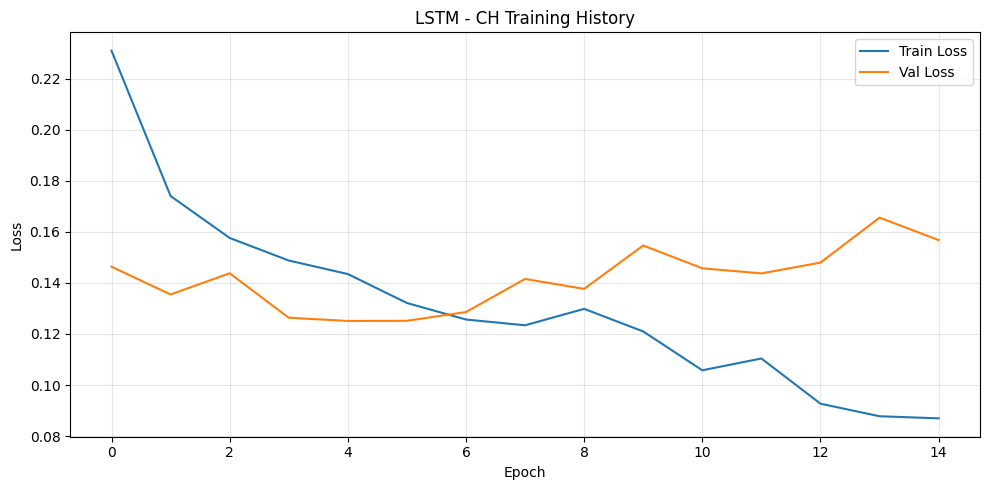

  [CH - LSTM] RMSE: 477.07, MAE: 363.60, MAPE: 5.61%
  Anomaly ML - PR-AUC: 0.035, F1@P=0.80: 0.250


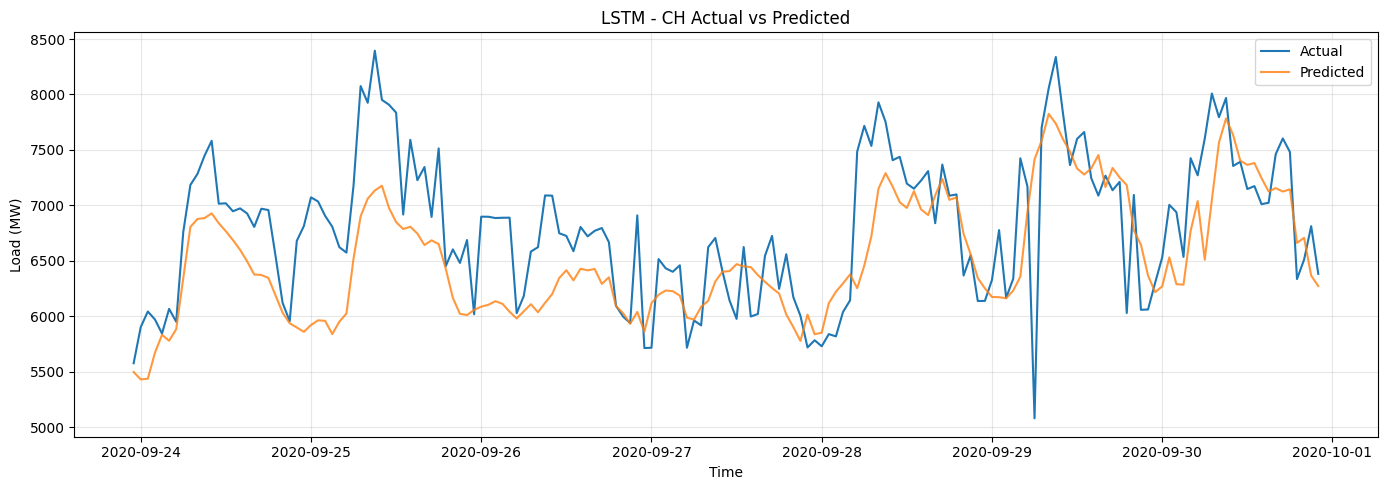


--- Training LSTM_Attention for CH ---
Epoch 10/50 - Train Loss: 0.1908, Val Loss: 0.2068
Epoch 20/50 - Train Loss: 0.0989, Val Loss: 0.2412
Early stopping at epoch 21


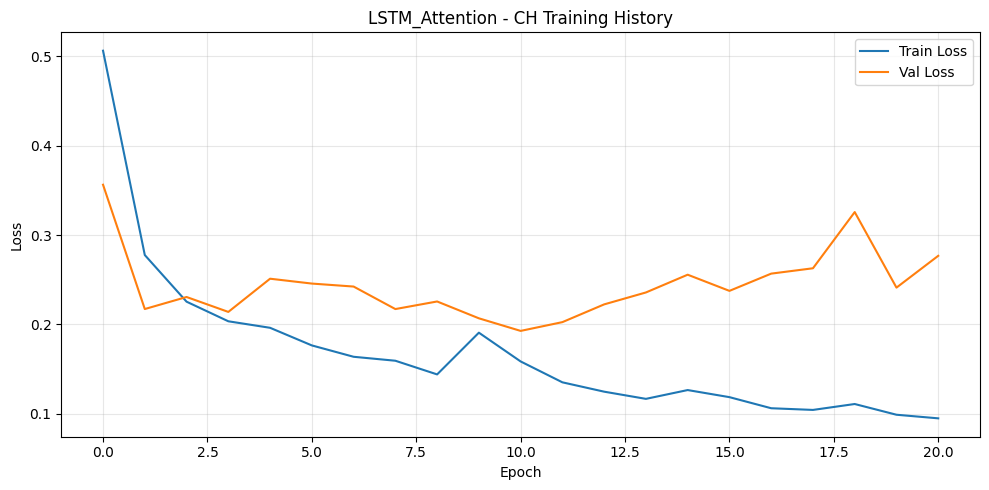

  [CH - LSTM_Attention] RMSE: 515.07, MAE: 400.82, MAPE: 6.18%
  Anomaly ML - PR-AUC: 0.065, F1@P=0.80: 0.222


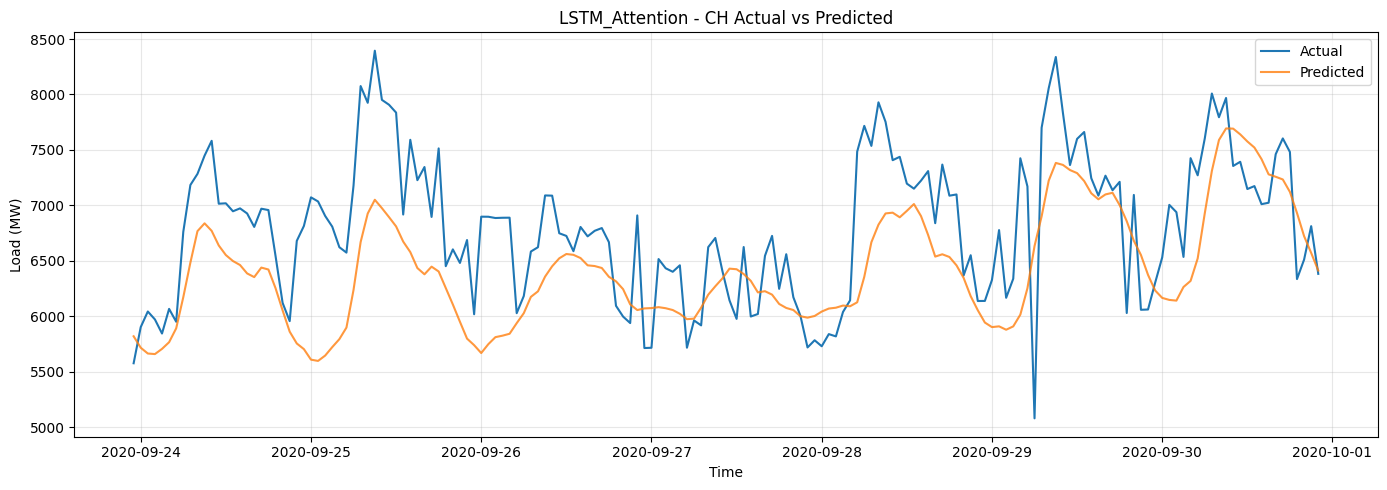


Processing country: FR

Preparing data for FR...
  Shape: (50357, 11)
  Date range: 2015-01-01 01:00:00+00:00 to 2020-09-30 22:00:00+00:00
  Load range: 29398 to 158000
Train: 40285, Val: 5036, Test: 5036
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for FR ---
Epoch 10/50 - Train Loss: 0.0283, Val Loss: 0.0327
Early stopping at epoch 18


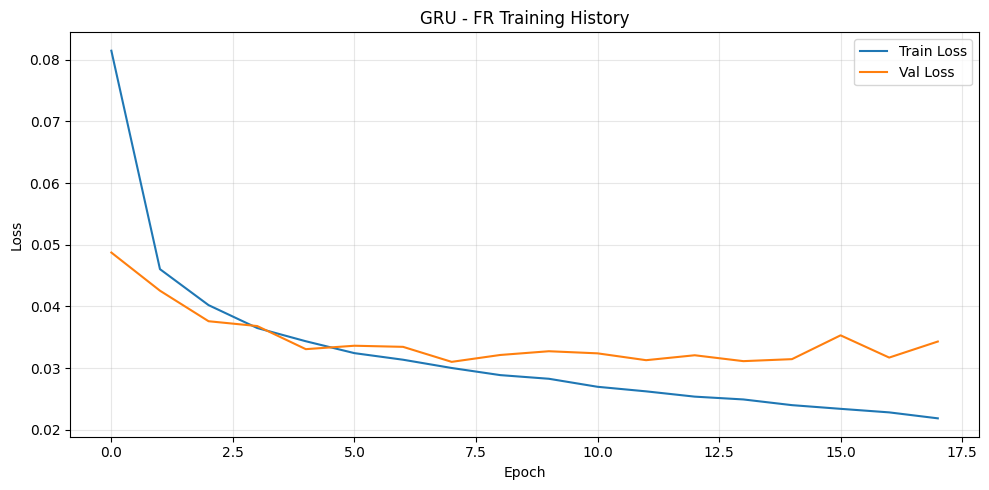

  [FR - GRU] RMSE: 2996.17, MAE: 2012.38, MAPE: 4.76%
  Anomaly ML - PR-AUC: 0.036, F1@P=0.80: 0.108


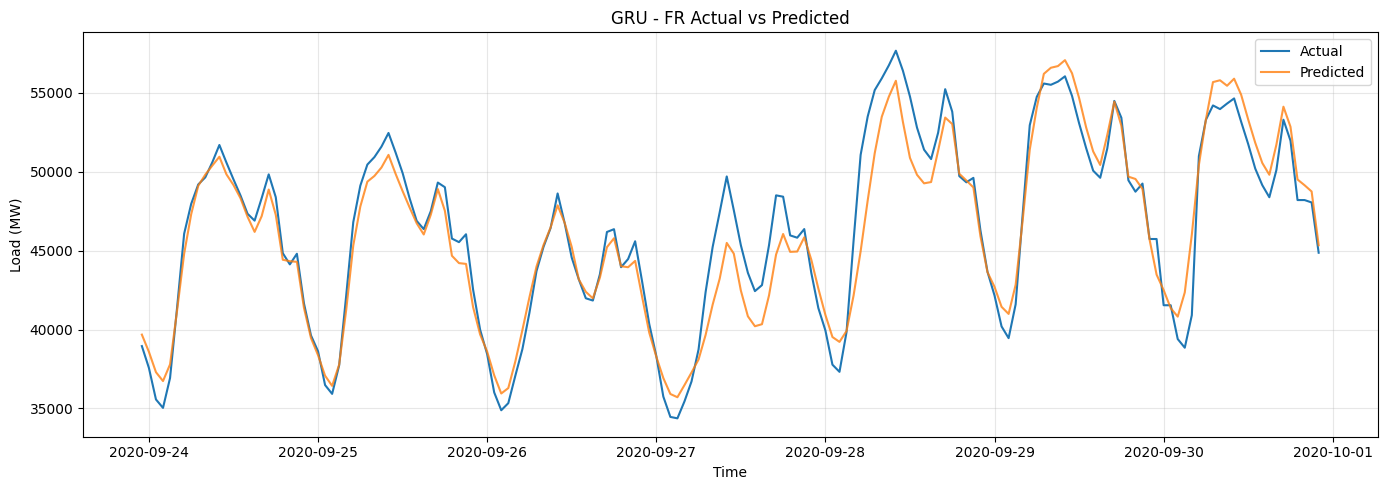


--- Training LSTM for FR ---
Epoch 10/50 - Train Loss: 0.0297, Val Loss: 0.0317
Epoch 20/50 - Train Loss: 0.0240, Val Loss: 0.0339
Early stopping at epoch 27


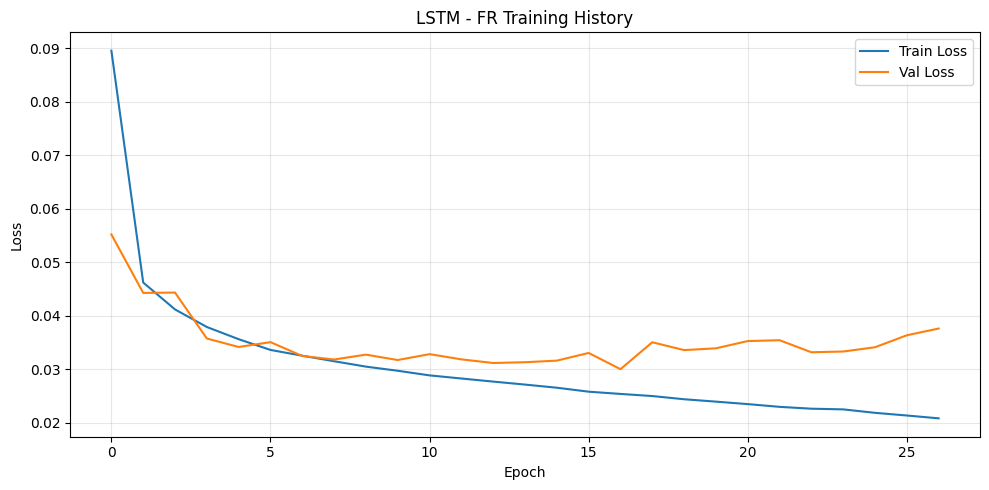

  [FR - LSTM] RMSE: 2824.07, MAE: 1857.35, MAPE: 4.35%
  Anomaly ML - PR-AUC: 0.018, F1@P=0.80: 0.067


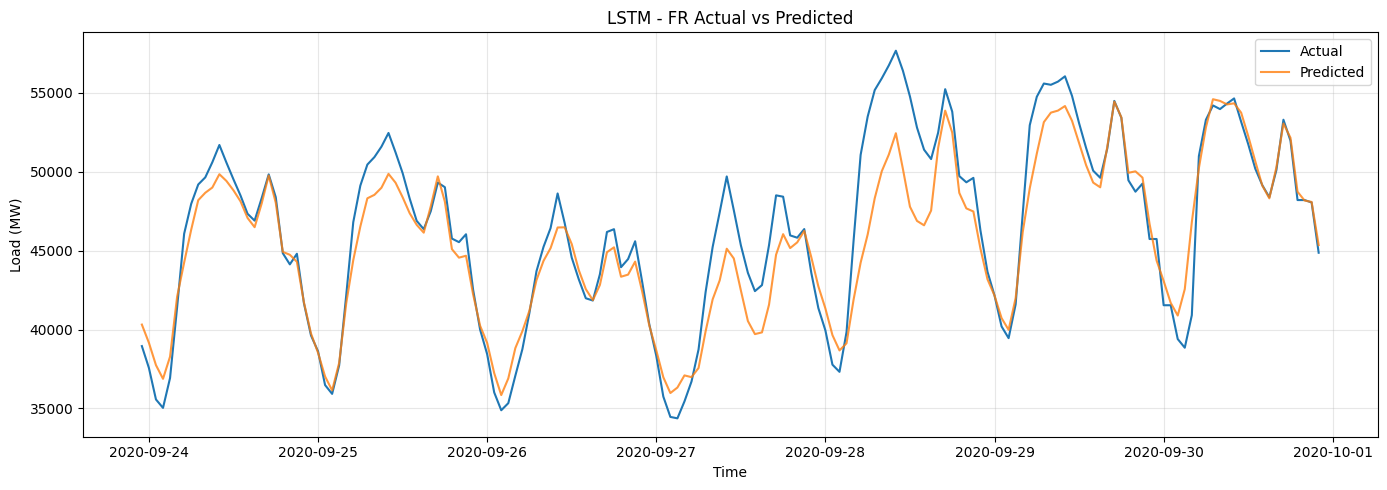


--- Training LSTM_Attention for FR ---
Epoch 10/50 - Train Loss: 0.0506, Val Loss: 0.0654
Epoch 20/50 - Train Loss: 0.0295, Val Loss: 0.0746
Early stopping at epoch 20


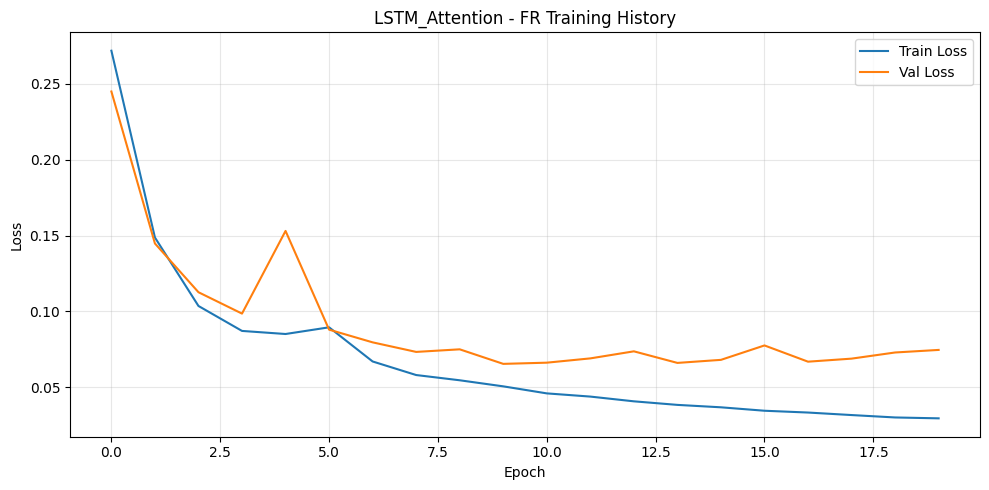

  [FR - LSTM_Attention] RMSE: 3422.83, MAE: 2426.38, MAPE: 5.83%
  Anomaly ML - PR-AUC: 0.279, F1@P=0.80: 0.667


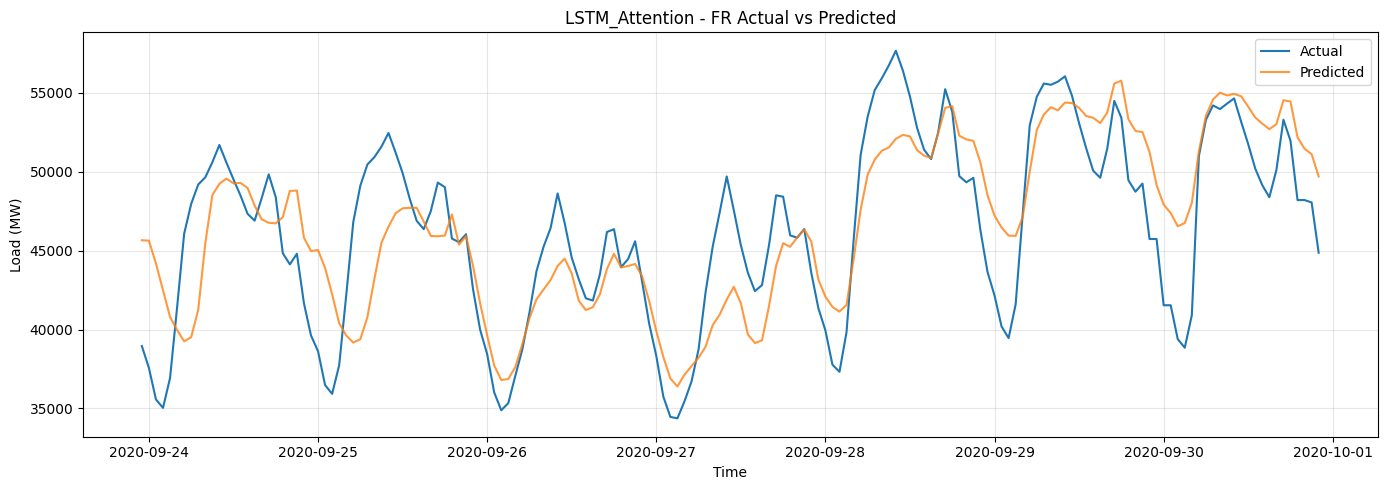


Processing country: AT

Preparing data for AT...
  Shape: (50400, 11)
  Date range: 2015-01-01 00:00:00+00:00 to 2020-09-30 23:00:00+00:00
  Load range: 664 to 10803
Train: 40320, Val: 5040, Test: 5040
Debug: Creating train_dataset...
Debug: Creating val_dataset...
Debug: Creating test_dataset...
Debug: Creating train_loader...
Debug: Creating val_loader...
Debug: Creating test_loader...
Debug: All dataloaders created, returning...

--- Training GRU for AT ---
Epoch 10/50 - Train Loss: 0.0588, Val Loss: 0.0396
Epoch 20/50 - Train Loss: 0.0390, Val Loss: 0.0509
Early stopping at epoch 22


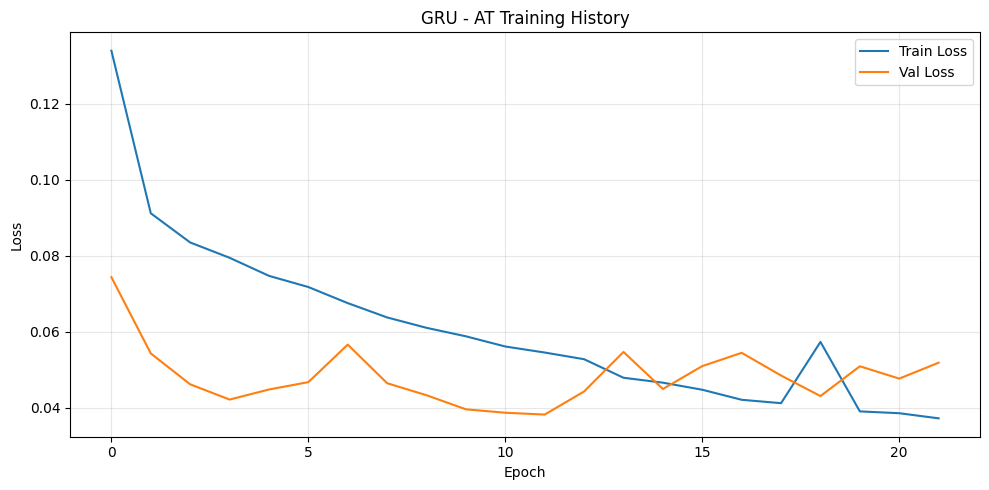

  [AT - GRU] RMSE: 333.53, MAE: 223.42, MAPE: 3.52%
  Anomaly ML - PR-AUC: 0.105, F1@P=0.80: 0.077


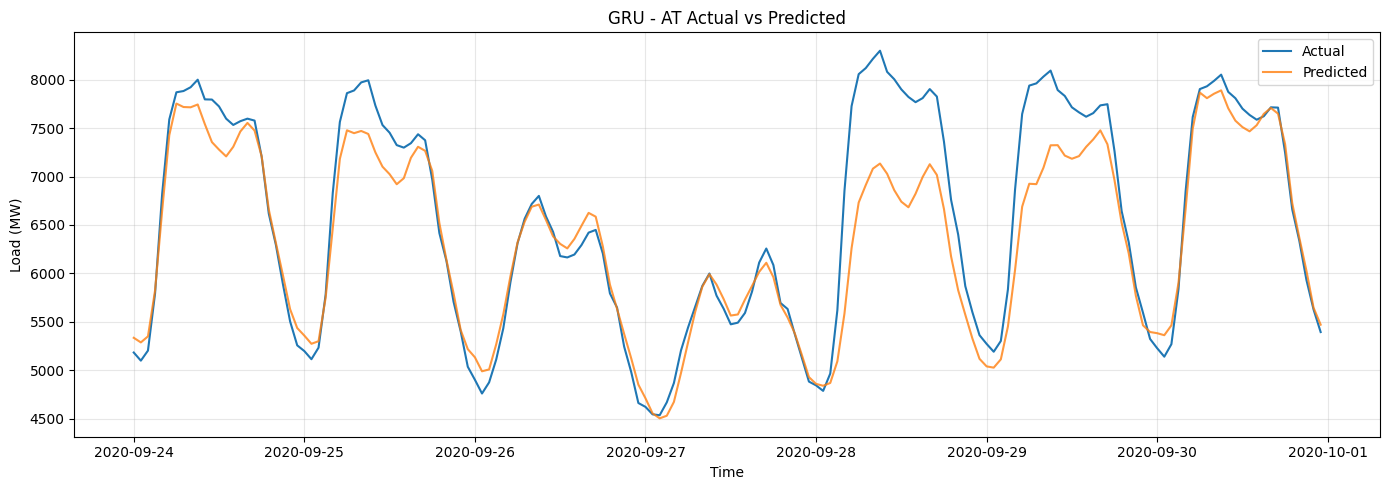


--- Training LSTM for AT ---
Epoch 10/50 - Train Loss: 0.0623, Val Loss: 0.0659
Early stopping at epoch 14


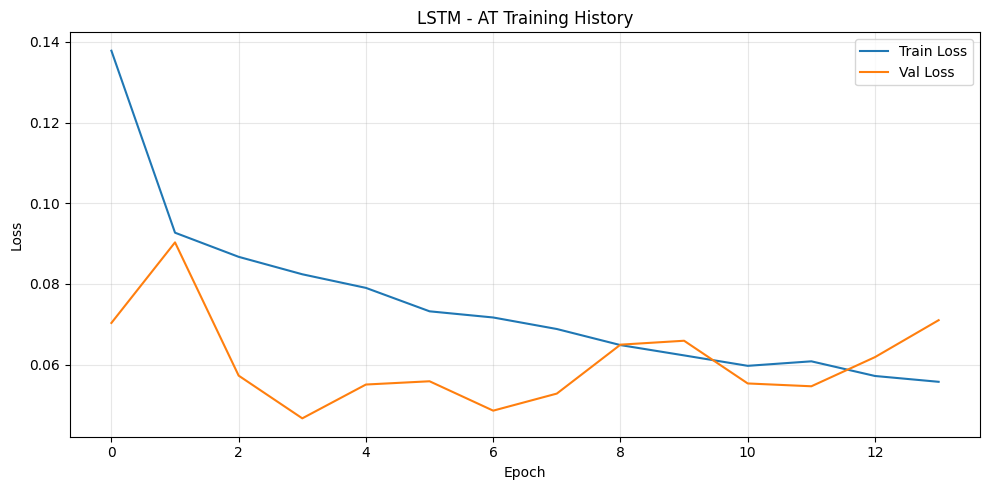

  [AT - LSTM] RMSE: 306.34, MAE: 211.97, MAPE: 3.38%
  Anomaly ML - PR-AUC: 0.340, F1@P=0.80: 0.417


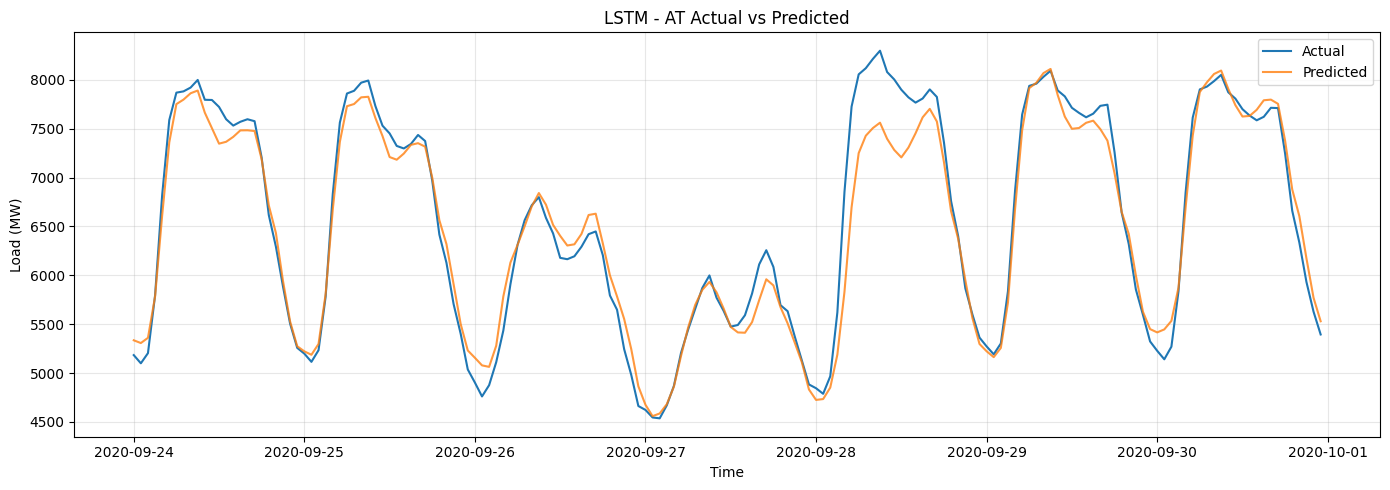


--- Training LSTM_Attention for AT ---
Epoch 10/50 - Train Loss: 0.0797, Val Loss: 0.0815
Epoch 20/50 - Train Loss: 0.0534, Val Loss: 0.0690
Early stopping at epoch 29


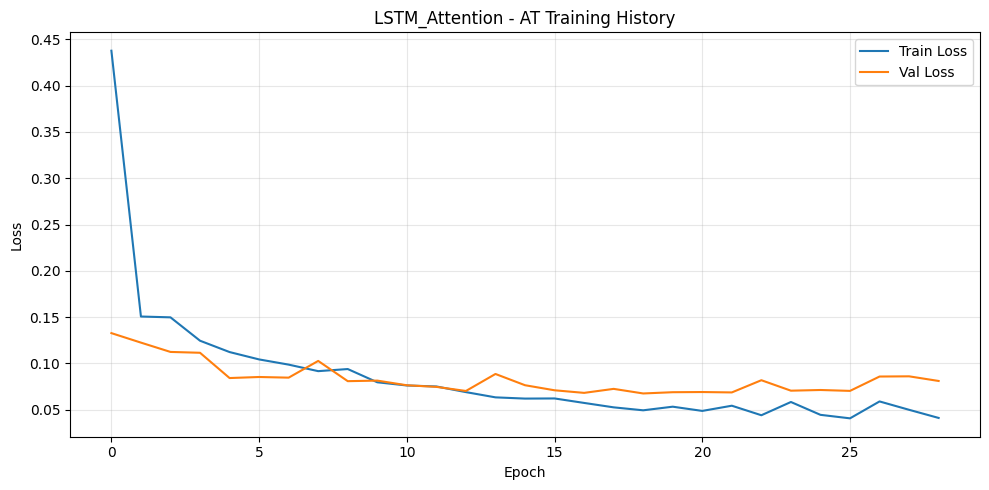

  [AT - LSTM_Attention] RMSE: 350.01, MAE: 242.39, MAPE: 3.89%
  Anomaly ML - PR-AUC: 0.085, F1@P=0.80: 0.114


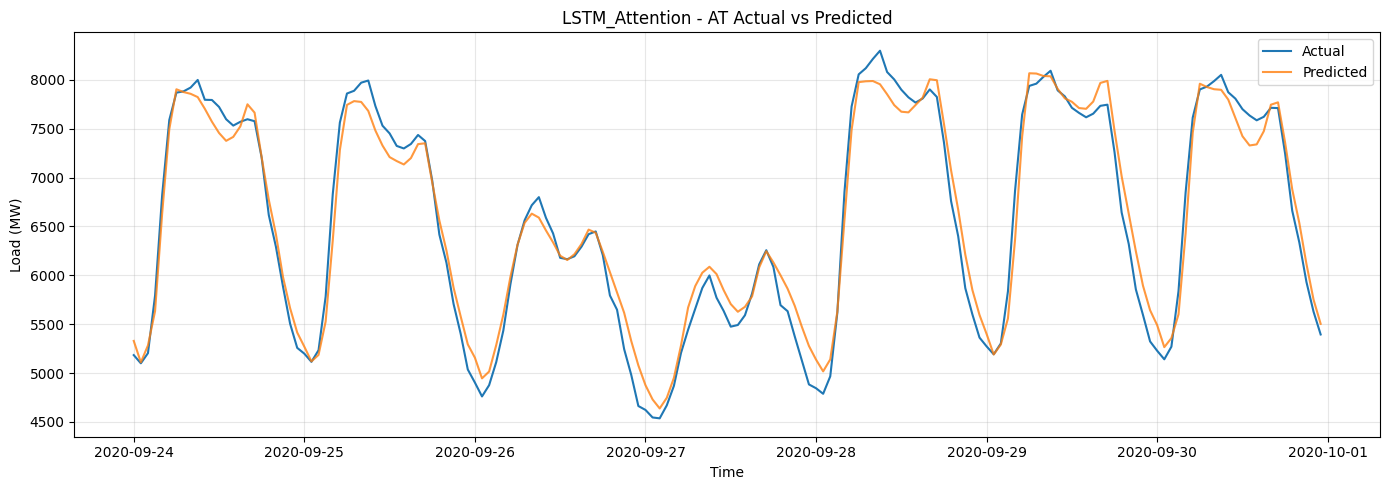


==================== MODEL DASHBOARD SUMMARY ====================
  country           model           MSE         RMSE          MAE      MAPE  \
0      CH             GRU  2.397994e+05   489.693148   359.306898  5.636726   
1      CH            LSTM  2.275982e+05   477.072575   363.597546  5.605711   
2      CH  LSTM_Attention  2.653015e+05   515.074255   400.824958  6.179927   
3      FR             GRU  8.977058e+06  2996.173971  2012.379168  4.761010   
4      FR            LSTM  7.975394e+06  2824.074059  1857.353061  4.354750   
5      FR  LSTM_Attention  1.171574e+07  3422.825686  2426.383927  5.834234   
6      AT             GRU  1.112396e+05   333.526042   223.424615  3.522943   
7      AT            LSTM  9.384691e+04   306.344427   211.967395  3.382171   
8      AT  LSTM_Attention  1.225072e+05   350.010221   242.393149  3.890610   

      sMAPE      MASE    PR_AUC  F1_at_P80  
0  5.613667  1.599493  0.048507   0.153846  
1  5.703246  1.618593  0.034690   0.250000  
2  6.28

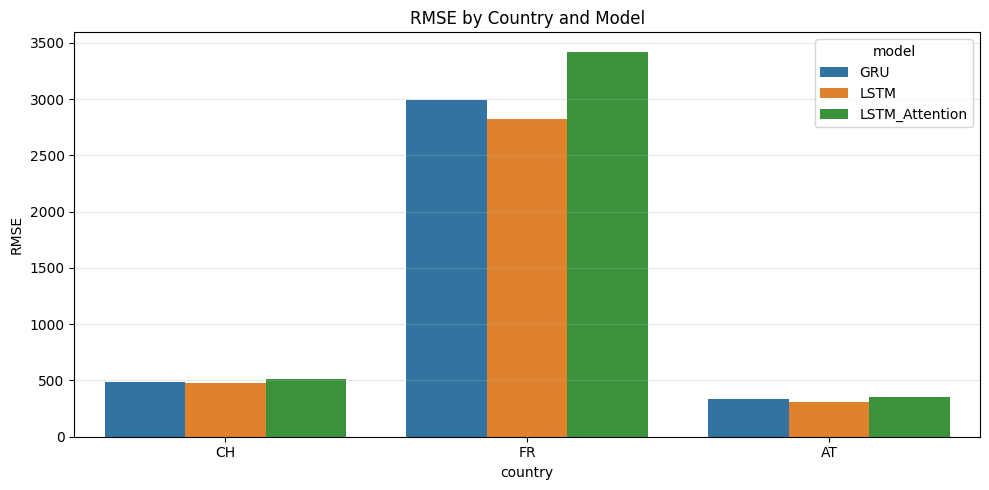

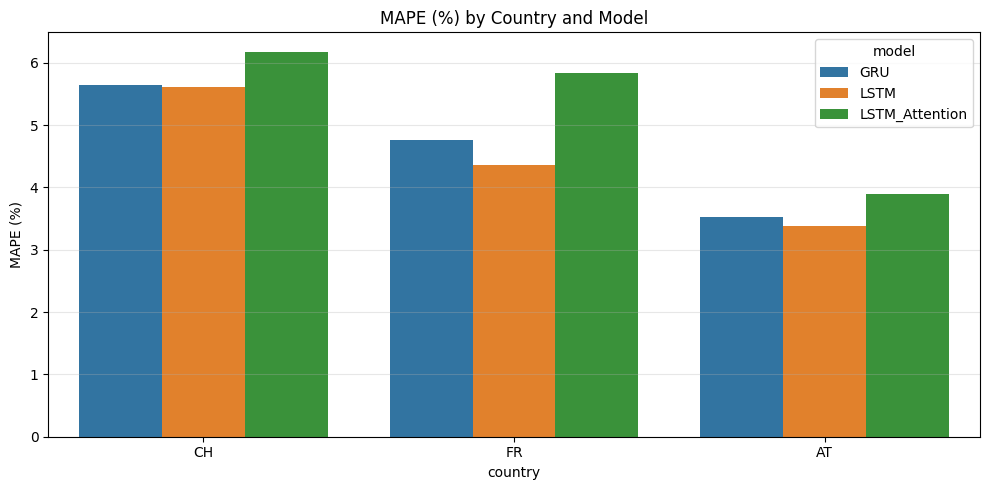

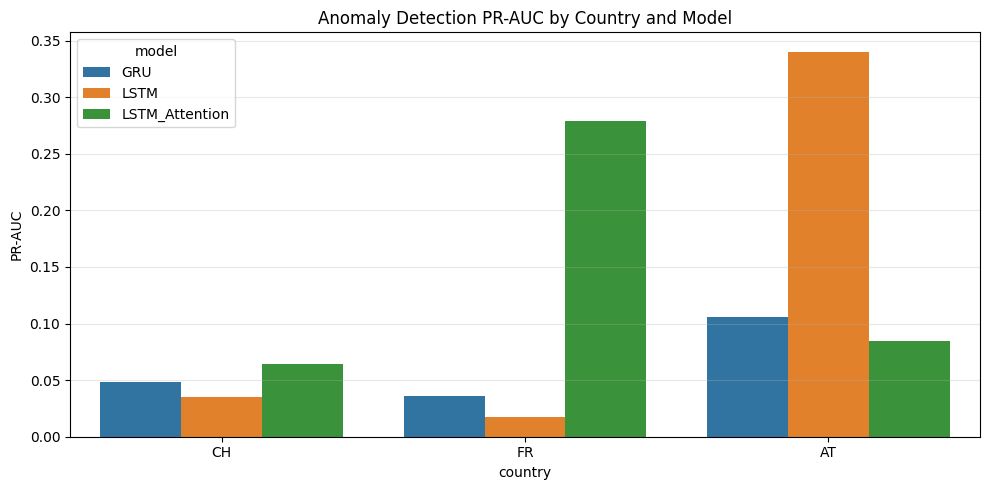


Saving all artifacts...

SAVING MODEL ARTIFACTS
✓ Saved configuration to: saved_models/config_20251127_134259.json
✓ Saved dashboard summary to: saved_models/dashboard_summary_20251127_134259.csv
✓ Saved CH GRU model to: saved_models/CH/GRU/model_20251127_134259.pth
✓ Saved CH GRU metrics to: saved_models/CH/GRU/metrics_20251127_134259.json
✓ Saved CH LSTM model to: saved_models/CH/LSTM/model_20251127_134259.pth
✓ Saved CH LSTM metrics to: saved_models/CH/LSTM/metrics_20251127_134259.json
✓ Saved CH LSTM_Attention model to: saved_models/CH/LSTM_Attention/model_20251127_134259.pth
✓ Saved CH LSTM_Attention metrics to: saved_models/CH/LSTM_Attention/metrics_20251127_134259.json
✓ Saved FR GRU model to: saved_models/FR/GRU/model_20251127_134259.pth
✓ Saved FR GRU metrics to: saved_models/FR/GRU/metrics_20251127_134259.json
✓ Saved FR LSTM model to: saved_models/FR/LSTM/model_20251127_134259.pth
✓ Saved FR LSTM metrics to: saved_models/FR/LSTM/metrics_20251127_134259.json
✓ Saved FR LSTM_

In [ ]:
import torch
import joblib
import json
import os
from datetime import datetime

def save_model_artifacts(all_results, dashboard_df, config, out_dir="saved_models"):
    """
    Save all models, scalers, metrics, and configuration for later use.

    Args:
        all_results: Dictionary containing all country results with models
        dashboard_df: DataFrame with metrics summary
        config: Configuration dictionary
        out_dir: Output directory for saving artifacts
    """
    os.makedirs(out_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print("\n" + "="*80)
    print("SAVING MODEL ARTIFACTS")
    print("="*80)

    # 1. Save configuration
    config_path = os.path.join(out_dir, f"config_{timestamp}.json")
    with open(config_path, 'w') as f:
        # Convert non-serializable items
        config_save = config.copy()
        config_save['device'] = str(config_save['device'])
        json.dump(config_save, f, indent=4)
    print(f"✓ Saved configuration to: {config_path}")

    # 2. Save dashboard summary
    csv_path = os.path.join(out_dir, f"dashboard_summary_{timestamp}.csv")
    dashboard_df.to_csv(csv_path, index=False)
    print(f"✓ Saved dashboard summary to: {csv_path}")

    # 3. Save models and scalers for each country and model type
    for country, models_info in all_results.items():
        country_dir = os.path.join(out_dir, country)
        os.makedirs(country_dir, exist_ok=True)

        for model_name, info in models_info.items():
            model_dir = os.path.join(country_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)

            # Save PyTorch model state dict
            model = info['model']
            model_path = os.path.join(model_dir, f"model_{timestamp}.pth")
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_architecture': model.__class__.__name__,
                'input_size': model.gru.input_size if hasattr(model, 'gru') else model.lstm.input_size,
                'hidden_size': model.hidden_size,
                'num_layers': model.num_layers,
                'output_size': CONFIG['horizon'],
                'timestamp': timestamp
            }, model_path)
            print(f"✓ Saved {country} {model_name} model to: {model_path}")

            # Save metrics
            metrics_path = os.path.join(model_dir, f"metrics_{timestamp}.json")
            metrics_data = {
                'forecast_metrics': info.get('forecast_metrics', {}),
                'anomaly_metrics': info.get('anomaly_metrics', {}),
                'train_losses': info.get('train_losses', []),
                'val_losses': info.get('val_losses', [])
            }
            with open(metrics_path, 'w') as f:
                json.dump(metrics_data, f, indent=4)
            print(f"✓ Saved {country} {model_name} metrics to: {metrics_path}")

    # 4. Save full results pickle (backup)
    pkl_path = os.path.join(out_dir, f"all_results_{timestamp}.pkl")
    # Remove model objects before pickling to reduce size
    results_for_pickle = {}
    for country, models_info in all_results.items():
        results_for_pickle[country] = {}
        for model_name, info in models_info.items():
            results_for_pickle[country][model_name] = {
                'forecast_metrics': info.get('forecast_metrics', {}),
                'anomaly_metrics': info.get('anomaly_metrics', {}),
                'train_losses': info.get('train_losses', []),
                'val_losses': info.get('val_losses', [])
            }
    joblib.dump(results_for_pickle, pkl_path)
    print(f"✓ Saved pickled results to: {pkl_path}")

    # 5. Create a summary file
    summary_path = os.path.join(out_dir, f"save_summary_{timestamp}.txt")
    with open(summary_path, 'w') as f:
        f.write(f"Model Artifacts Save Summary\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"="*80 + "\n\n")
        f.write(f"Countries processed: {', '.join(all_results.keys())}\n")
        f.write(f"Models per country: {', '.join(list(all_results[list(all_results.keys())[0]].keys()))}\n")
        f.write(f"\nSaved files:\n")
        f.write(f"- Configuration: {config_path}\n")
        f.write(f"- Dashboard CSV: {csv_path}\n")
        f.write(f"- Full results pickle: {pkl_path}\n")
        f.write(f"\nModel weights saved in:\n")
        for country in all_results.keys():
            f.write(f"- {os.path.join(out_dir, country)}/\n")

    print(f"✓ Saved summary to: {summary_path}")
    print("\n" + "="*80)
    print(f"ALL ARTIFACTS SAVED SUCCESSFULLY TO: {out_dir}")
    print("="*80 + "\n")

    return out_dir


def load_model(country, model_name, model_path, device='cpu'):
    """
    Load a saved model from checkpoint.

    Args:
        country: Country code (e.g., 'CH', 'FR', 'AT')
        model_name: Model type ('GRU', 'LSTM', 'LSTM_Attention')
        model_path: Path to the saved .pth file
        device: Device to load model on

    Returns:
        Loaded model
    """
    checkpoint = torch.load(model_path, map_location=device)

    # Recreate model architecture
    if model_name == 'GRU':
        model = GRUModel(
            input_size=checkpoint['input_size'],
            hidden_size=checkpoint['hidden_size'],
            num_layers=checkpoint['num_layers'],
            output_size=checkpoint['output_size'],
            dropout=CONFIG.get('dropout', 0.2)
        )
    elif model_name == 'LSTM':
        model = LSTMModel(
            input_size=checkpoint['input_size'],
            hidden_size=checkpoint['hidden_size'],
            num_layers=checkpoint['num_layers'],
            output_size=checkpoint['output_size'],
            dropout=CONFIG.get('dropout', 0.2)
        )
    elif model_name == 'LSTM_Attention':
        model = LSTMAttentionModel(
            input_size=checkpoint['input_size'],
            hidden_size=checkpoint['hidden_size'],
            num_layers=checkpoint['num_layers'],
            output_size=checkpoint['output_size'],
            dropout=CONFIG.get('dropout', 0.2)
        )
    else:
        raise ValueError(f"Unknown model type: {model_name}")

    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    print(f"✓ Loaded {country} {model_name} model from {model_path}")
    return model


def save_to_google_drive(out_dir, drive_folder="LoadForecastModels"):
    """
    Save artifacts to Google Drive (for Colab environments).

    Args:
        out_dir: Local directory with saved artifacts
        drive_folder: Folder name in Google Drive
    """
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        import shutil
        drive_path = f'/content/drive/MyDrive/{drive_folder}'

        if os.path.exists(drive_path):
            shutil.rmtree(drive_path)

        shutil.copytree(out_dir, drive_path)
        print(f"\n✓ Copied all artifacts to Google Drive: {drive_path}")

    except ImportError:
        print("\n⚠ Not in Colab environment. Skipping Google Drive save.")
    except Exception as e:
        print(f"\n✗ Error saving to Google Drive: {e}")


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Run the complete pipeline
    print("Starting pipeline...")
    all_results, dashboard_df = run_pipeline()

    # Save everything locally
    print("\nSaving all artifacts...")
    save_dir = save_model_artifacts(all_results, dashboard_df, CONFIG)

    # Optional: Save to Google Drive if in Colab
    print("\nAttempting to save to Google Drive...")
    save_to_google_drive(save_dir)

    print("\n🎉 PIPELINE COMPLETE! All models and artifacts saved.")

    # Example: Load a specific model later
    # model = load_model(
    #     country='CH',
    #     model_name='LSTM_Attention',
    #     model_path='saved_models/CH/LSTM_Attention/model_20241127_123456.pth',
    #     device=CONFIG['device']
    # )

In [ ]:
!zip "/content/saved_models"


zip error: Nothing to do! (/content/saved_models.zip)


In [ ]:
!zip -r /content/saved_models.zip /content/saved_models

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/FR/ (stored 0%)
  adding: content/saved_models/FR/LSTM_Attention/ (stored 0%)
  adding: content/saved_models/FR/LSTM_Attention/metrics_20251127_134259.json (deflated 61%)
  adding: content/saved_models/FR/LSTM_Attention/model_20251127_134259.pth (deflated 7%)
  adding: content/saved_models/FR/LSTM/ (stored 0%)
  adding: content/saved_models/FR/LSTM/metrics_20251127_134259.json (deflated 62%)
  adding: content/saved_models/FR/LSTM/model_20251127_134259.pth (deflated 7%)
  adding: content/saved_models/FR/GRU/ (stored 0%)
  adding: content/saved_models/FR/GRU/metrics_20251127_134259.json (deflated 60%)
  adding: content/saved_models/FR/GRU/model_20251127_134259.pth (deflated 7%)
  adding: content/saved_models/dashboard_summary_20251127_134259.csv (deflated 47%)
  adding: content/saved_models/save_summary_20251127_134259.txt (deflated 51%)
  adding: content/saved_models/all_results_20251127_134259.pkl (deflated 27%)